In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import sknetwork as skn
import networkx as nx
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

from gensim.models import Word2Vec

from node2vec import Node2Vec
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

# Variáveis globais

In [4]:
NETWORK_HRPD_BASE_PATH = Path("/Users/alfredoguilhermedasilvasouza/IdeaProjects/acdbio-mlnet-driver-discovery/acdbio_mlnet_driver_discovery/data/networks/silver")
MAF_BASE_PATH = Path("/Users/alfredoguilhermedasilvasouza/IdeaProjects/acdbio-mlnet-driver-discovery/acdbio_mlnet_driver_discovery/data/mafs/gold")
INTOGEN_BASE_PATH = Path("/Users/alfredoguilhermedasilvasouza/IdeaProjects/acdbio-mlnet-driver-discovery/acdbio_mlnet_driver_discovery/data/benchmarks/intogen")
NETWORK_HRPD_FEATURES_BASE_PATH = Path("/Users/alfredoguilhermedasilvasouza/IdeaProjects/acdbio-mlnet-driver-discovery/acdbio_mlnet_driver_discovery/data/network_features")
CGC_BASE_PATH = Path("/Users/alfredoguilhermedasilvasouza/IdeaProjects/acdbio-mlnet-driver-discovery/acdbio_mlnet_driver_discovery/data/benchmarks/CGC")
FALSE_POSITIVE_BASE_PATH = Path("/Users/alfredoguilhermedasilvasouza/IdeaProjects/acdbio-mlnet-driver-discovery/acdbio_mlnet_driver_discovery/data/benchmarks/false_positives")
FIG_BASE_PATH = "/Users/alfredoguilhermedasilvasouza/Codes/Notebooks/GNN/results/STAD/local/stad_local_"

In [5]:
NETWORK_HPRD_PATH = NETWORK_HRPD_BASE_PATH.joinpath("HPRD.txt")
MAF_PATH = MAF_BASE_PATH.joinpath("stad_data_mutations_extended.parquet")
INTOGEN_PATH = INTOGEN_BASE_PATH.joinpath("IntOGen-DriverGenes_STAD_TCGA.tsv")
NETWORK_FEATURES_HPRD_PATH = NETWORK_HRPD_FEATURES_BASE_PATH.joinpath("HPRD_features.parquet")
CGC_PATH = CGC_BASE_PATH.joinpath("CGC_COSMIC_Census_allTue Jul 27 01_37_31 2021.tsv")
FALSE_POSITIVE_PATH = FALSE_POSITIVE_BASE_PATH.joinpath("false_positives_NCG6.txt")

# Funções

In [6]:
def carregar_dados(network_path, maf_path, cgc_path):
    """Carrega a rede de genes, dados de mutação e lista de genes drivers."""
    arestas = pd.read_csv(network_path, sep=' ', header=None, names=['Gene1', 'Gene2'])
    G = nx.from_pandas_edgelist(arestas, 'Gene1', 'Gene2')
    
    maf_df = pd.read_parquet(maf_path)
    cgc_df = pd.read_csv(cgc_path, sep='\t')
    
    return G, maf_df, cgc_df

In [7]:
def gerar_embeddings(G, dimensions=64, walk_length=30, num_walks=200, workers=4, p=1, q=1):
    """Gera embeddings usando node2vec."""
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, p=p, q=q)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model

In [8]:
def visualizar_embeddings_basico(embeddings, title="Visualização simples dos Embeddings"):
    """Visualiza embeddings em 2D usando PCA."""
    embeddings_matrix = [embeddings[str(gene)] for gene in G.nodes]
    pca = PCA(n_components=2)
    reduced_embeddings_2d = pca.fit_transform(embeddings_matrix)
    plt.scatter(reduced_embeddings_2d[:, 0], reduced_embeddings_2d[:, 1], s=1)
    plt.show()

In [9]:
def visualizar_embeddings(embeddings, gene_names, highlight_genes, title="Visualização dos Embeddings", name_fig="embedding_visualization_1_global.jpg"):
    """Visualiza embeddings em 2D usando PCA."""
    embeddings_matrix = [embeddings[str(gene)] for gene in gene_names]
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings_matrix)
    
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                c=['red' if gene in highlight_genes else 'blue' for gene in gene_names], s=10)
    plt.title(title)
    plt.savefig(name_fig, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()



def visualizar_embeddings_3d(embeddings, gene_names, highlight_genes, title="Visualização dos Embeddings em 3D com PCA", 
                            highlight_color='red', default_color='blue', highlight_size=20, default_size=1, 
                            figsize=(24, 16), save_path=None):
    """
    Visualiza embeddings em 3D usando PCA, destacando genes específicos.

    Parâmetros:
    - embeddings: Dicionário ou lista de embeddings, onde a chave ou índice corresponde ao nome do gene.
    - gene_names: Lista de nomes dos genes correspondentes aos embeddings.
    - highlight_genes: Lista de genes a serem destacados no gráfico.
    - title: Título do gráfico.
    - highlight_color: Cor dos pontos destacados (genes de interesse).
    - default_color: Cor dos pontos não destacados.
    - highlight_size: Tamanho dos pontos destacados.
    - default_size: Tamanho dos pontos não destacados.
    - figsize: Tamanho da figura (largura, altura).
    - save_path: Caminho para salvar a figura. Se None, a figura não será salva.
    """
    # Converte embeddings para uma matriz
    embeddings_matrix = [embeddings[str(gene)] for gene in gene_names]

    # Redução de dimensionalidade para 3 componentes
    pca = PCA(n_components=3)
    reduced_embeddings_3d = pca.fit_transform(embeddings_matrix)

    # Define as cores e tamanhos dos pontos
    colors = [highlight_color if gene in highlight_genes else default_color for gene in gene_names]
    sizes = [highlight_size if gene in highlight_genes else default_size for gene in gene_names]

    # Configuração do gráfico 3D
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plotagem dos pontos
    scatter = ax.scatter(reduced_embeddings_3d[:, 0], reduced_embeddings_3d[:, 1], reduced_embeddings_3d[:, 2], 
                         c=colors, s=sizes)

    # Adiciona a legenda
    for color, label in [(highlight_color, 'Driver'), (default_color, 'Non-driver')]:
        ax.scatter([], [], [], color=color, label=label, s=50)  # pontos vazios para a legenda

    ax.legend(title='Genes groups', loc='upper right')
    ax.set_xlabel('Principal component 1')
    ax.set_ylabel('Principal component 2')
    ax.set_zlabel('Principal component 3')
    plt.title(title)

    # Salva a figura, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format='jpg', dpi=300, bbox_inches='tight')

    plt.show()

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def visualizar_embeddings_3d_multigrupos(embeddings, gene_names, highlight_driver_genes, highlight_maf_genes, 
                                       title="Visualização dos Embeddings em 3D com PCA", 
                                       driver_color='red', driver_maf_color='black', maf_color='deepskyblue', 
                                       default_color='blue', driver_size=20, maf_size=2, default_size=1, 
                                       figsize=(24, 16), save_path=None):
    """
    Visualiza embeddings em 3D usando PCA, destacando múltiplos grupos de genes.

    Parâmetros:
    - embeddings: Dicionário ou lista de embeddings, onde a chave ou índice corresponde ao nome do gene.
    - gene_names: Lista de nomes dos genes correspondentes aos embeddings.
    - highlight_driver_genes: Lista de genes *drivers* a serem destacados.
    - highlight_maf_genes: Lista de genes presentes no MAF a serem destacados.
    - title: Título do gráfico.
    - driver_color: Cor dos genes *drivers*.
    - driver_maf_color: Cor dos genes que são *drivers* e estão no MAF.
    - maf_color: Cor dos genes presentes apenas no MAF.
    - default_color: Cor dos genes que não são *drivers* nem estão no MAF.
    - driver_size: Tamanho dos pontos para genes *drivers*.
    - maf_size: Tamanho dos pontos para genes presentes no MAF.
    - default_size: Tamanho dos pontos para outros genes.
    - figsize: Tamanho da figura (largura, altura).
    - save_path: Caminho para salvar a figura. Se None, a figura não será salva.
    """
    # Converte embeddings para uma matriz
    embeddings_matrix = [embeddings[str(gene)] for gene in gene_names]

    # Redução de dimensionalidade para 3 componentes
    pca = PCA(n_components=3)
    reduced_embeddings_3d = pca.fit_transform(embeddings_matrix)

    # Define as cores e tamanhos dos pontos
    colors = []
    sizes = []
    for gene in gene_names:
        if gene in highlight_driver_genes and gene in highlight_maf_genes:
            colors.append(driver_maf_color)
            sizes.append(driver_size)
        elif gene in highlight_driver_genes:
            colors.append(driver_color)
            sizes.append(driver_size)
        elif gene in highlight_maf_genes:
            colors.append(maf_color)
            sizes.append(maf_size)
        else:
            colors.append(default_color)
            sizes.append(default_size)

    # Configuração do gráfico 3D
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plotagem dos pontos
    scatter = ax.scatter(reduced_embeddings_3d[:, 0], reduced_embeddings_3d[:, 1], reduced_embeddings_3d[:, 2], 
                         c=colors, s=sizes)

    # Adiciona a legenda
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Driver', markerfacecolor=driver_color, markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Driver and present at MAF', markerfacecolor=driver_maf_color, markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Only present in MAF', markerfacecolor=maf_color, markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label="It's not a driver, nor is it on the MAF", markerfacecolor=default_color, markersize=10)
    ]
    ax.legend(handles=legend_elements, title='Genes groups', loc='upper right')

    # Configurações dos eixos e título
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.title(title)

    # Salva a figura, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format='jpg', dpi=300, bbox_inches='tight')

    plt.show()

In [11]:
def visualize_drivers_clustering(embeddings, colors, driver_color='red', eps=0.5, min_samples=5,
                                 title="Densidade dos Genes Drivers (CGC) com Clustering",
                                 figsize=(10, 8), save_path=None):
    """
    Realiza clustering (DBSCAN) nos embeddings dos genes drivers e visualiza os clusters em 2D,
    utilizando redução de dimensionalidade com PCA e plotagem com KDE e scatter plot.

    Parâmetros:
    - embeddings: Lista ou array dos embeddings dos genes.
    - colors: Lista de cores correspondente a cada embedding. Os embeddings serão filtrados
              para incluir apenas aqueles com a cor definida em 'driver_color'.
    - driver_color: Cor utilizada para identificar os genes drivers. Padrão é 'red'.
    - eps: Parâmetro eps do DBSCAN (distância máxima entre dois pontos para serem considerados vizinhos).
    - min_samples: Número mínimo de amostras em um cluster para DBSCAN.
    - title: Título do gráfico.
    - figsize: Tamanho da figura (largura, altura).
    - save_path: Caminho para salvar a figura. Se None, a figura não será salva.

    Retorna:
    - clusters: Array com os rótulos dos clusters atribuídos pelo DBSCAN.
    """
    # Filtra os embeddings dos genes drivers com base na cor
    drivers_embeddings = np.array([embeddings[i] for i in range(len(embeddings)) if colors[i] == driver_color])
    
    if drivers_embeddings.shape[0] == 0:
        raise ValueError("Nenhum embedding encontrado para a cor especificada: '{}'".format(driver_color))
    
    # Redução de dimensionalidade para 2 componentes para visualização
    pca = PCA(n_components=2)
    reduced_drivers_embeddings_2d = pca.fit_transform(drivers_embeddings)
    
    # Clustering de densidade com DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(reduced_drivers_embeddings_2d)
    
    # Visualização dos clusters com KDE e scatter plot
    plt.figure(figsize=figsize)
    sns.kdeplot(x=reduced_drivers_embeddings_2d[:, 0], y=reduced_drivers_embeddings_2d[:, 1],
                cmap="Reds", shade=True, bw_adjust=0.5)
    plt.scatter(reduced_drivers_embeddings_2d[:, 0], reduced_drivers_embeddings_2d[:, 1],
                c=clusters, cmap='viridis', s=20)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    cbar = plt.colorbar(label='Cluster ID')
    
    # Salva a figura, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format='jpg', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return clusters, reduced_drivers_embeddings_2d


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

def visualize_clustering_by_color(embeddings, colors, target_color='black',
                                  eps=0.5, min_samples=5,
                                  title="Densidade dos Genes Drivers (CGC + MAF) com Clustering",
                                  figsize=(10, 8), save_path=None):
    """
    Realiza clustering com DBSCAN nos embeddings dos genes filtrados pela cor especificada
    e visualiza os clusters utilizando redução de dimensionalidade (PCA) para 2 componentes,
    combinando KDE e scatter plot.

    Parâmetros:
    - embeddings: Lista ou array dos embeddings dos genes.
    - colors: Lista de cores correspondente a cada embedding.
    - target_color: Cor utilizada para filtrar os embeddings (padrão: 'black').
    - eps: Parâmetro eps do DBSCAN (distância máxima entre dois pontos para serem considerados vizinhos).
    - min_samples: Número mínimo de amostras para formar um cluster no DBSCAN.
    - title: Título do gráfico.
    - figsize: Tamanho da figura (largura, altura).
    - save_path: Caminho para salvar a figura. Se None, a figura não será salva.

    Retorna:
    - clusters: Array com os rótulos dos clusters obtidos pelo DBSCAN.
    """
    # Filtra os embeddings com base na cor especificada
    filtered_embeddings = np.array([embeddings[i] for i in range(len(embeddings)) if colors[i] == target_color])
    
    if filtered_embeddings.shape[0] == 0:
        raise ValueError("Nenhum embedding encontrado para a cor especificada: '{}'".format(target_color))
    
    # Redução de dimensionalidade para 2 componentes para visualização
    pca = PCA(n_components=2)
    reduced_embeddings_2d = pca.fit_transform(filtered_embeddings)
    
    # Clustering de densidade com DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(reduced_embeddings_2d)
    
    # Visualização dos clusters com KDE e scatter plot
    plt.figure(figsize=figsize)
    sns.kdeplot(x=reduced_embeddings_2d[:, 0], y=reduced_embeddings_2d[:, 1],
                cmap="Reds", shade=True, bw_adjust=0.5)
    plt.scatter(reduced_embeddings_2d[:, 0], reduced_embeddings_2d[:, 1],
                c=clusters, cmap='viridis', s=20)
    plt.title(title)
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.colorbar(label='Cluster ID')
    
    # Salva a figura se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format='jpg', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return clusters


In [13]:
def analisar_genes_nao_drivers_em_regioes_drivers(embeddings, gene_names, highlight_genes, eps=0.5, min_samples=5):
    """
    Analisa as características dos genes não drivers nas regiões onde os genes drivers estão agrupados.

    Parâmetros:
    - embeddings: Lista ou array dos embeddings dos genes.
    - gene_names: Lista de nomes dos genes correspondentes aos embeddings.
    - highlight_genes: Lista de genes drivers a serem destacados.
    - eps: Parâmetro eps do DBSCAN (distância máxima entre dois pontos para serem considerados vizinhos).
    - min_samples: Número mínimo de amostras em um cluster para DBSCAN.

    Retorna:
    - Um DataFrame com as características dos genes não drivers nas regiões dos genes drivers.
    """
    
    # Filtra os embeddings dos genes drivers com base na cor
    drivers_embeddings = np.array([embeddings[i] for i in range(len(embeddings)) if gene_names[i] in highlight_genes])
    
    if drivers_embeddings.shape[0] == 0:
        raise ValueError("Nenhum embedding encontrado para os genes drivers especificados.")
    
    # Redução de dimensionalidade para 2 componentes para visualização
    pca = PCA(n_components=2)
    reduced_drivers_embeddings_2d = pca.fit_transform(drivers_embeddings)
    
    # Clustering de densidade com DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(reduced_drivers_embeddings_2d)
    
    # Identificar os clusters onde os genes drivers estão agrupados
    unique_clusters = np.unique(clusters)
    
    # Coletar os genes não drivers nessas regiões
    genes_nao_drivers = []
    for cluster in unique_clusters:
        if cluster != -1:  # Ignorar outliers
            # Encontrar os índices dos genes drivers no cluster
            indices_drivers = np.where(clusters == cluster)[0]
            
            # Encontrar os embeddings dos genes drivers no cluster
            embeddings_drivers_cluster = drivers_embeddings[indices_drivers]
            
            # Encontrar os genes não drivers próximos aos genes drivers no cluster
            for i, gene in enumerate(gene_names):
                if gene not in highlight_genes:
                    embedding_gene = embeddings[i]
                    distancias = np.linalg.norm(embeddings_drivers_cluster - embedding_gene, axis=1)
                    if np.any(distancias < eps):
                        genes_nao_drivers.append(gene)
    
    # Remover duplicatas (caso um gene não driver esteja próximo a mais de um gene driver)
    genes_nao_drivers = list(set(genes_nao_drivers))
    
    # Análise das características dos genes não drivers
    # Aqui você pode adicionar a análise das características biológicas e de rede
    # Por exemplo, você pode usar o DataFrame maf_df para obter informações biológicas
    # e a rede G para obter informações sobre as conexões dos genes.
    
    # Exemplo de análise: contar o número de conexões dos genes não drivers na rede
    conexoes_genes_nao_drivers = []
    for gene in genes_nao_drivers:
        if gene in G.nodes:
            conexoes = len(list(G.neighbors(gene)))
            conexoes_genes_nao_drivers.append(conexoes)
        else:
            conexoes_genes_nao_drivers.append(0)
    
    # Criar um DataFrame com as características dos genes não drivers
    df_genes_nao_drivers = pd.DataFrame({
        'Gene': genes_nao_drivers,
        'Conexões_na_Rede': conexoes_genes_nao_drivers
    })
    
    return df_genes_nao_drivers

# Análise exploratória

### 1. Leitura das bases de dados, sendo:
1. Uma rede de genes
2. Uma base de dados de mutação de pacientes (MAF)
3. Uma base de dados de genes drivers (CGA)


In [14]:
G, maf_df, cgc_df = carregar_dados(NETWORK_HPRD_PATH, MAF_PATH, CGC_PATH)

In [15]:
cgc_list = cgc_df['Gene Symbol'].tolist()
maf_list = maf_df['Hugo_Symbol'].tolist()

### 3. treina um GNN ou Node2vec para gerar os embeddings de todos os vértices nesse grafo

#### Treinar e salvar o modelo
Salvar o modelo pq o treinamento demora bastante, assim não será necessário aguardar o treinamendo do modelo toda vez, e sim carregar o modelo já salvo.

In [16]:
# # Criação do modelo Node2Vec
# node2vec = Node2Vec(G, dimensions=128, walk_length=10, num_walks=200, workers=4, p=1, q=2)

In [17]:
# # Treinamento do modelo
# model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [18]:
# # Salvar o modelo treinado
# model.save("node2vec_model_local.model")

In [19]:
# carregar o modelo
modelo = Word2Vec.load("node2vec_model_local.model")

In [20]:
embeddings = modelo.wv
print(embeddings['CHRNA1'])

[ 0.34994015 -0.00699023 -0.24723668 -0.13867366  1.0815524  -0.12963569
  0.1941888  -0.31843594 -0.47856465  0.52721065 -0.4977989   0.51585203
 -0.08756178 -0.3122883   0.7621378   0.4869665   0.365906   -0.0540678
 -0.4539988   0.18373597 -0.5874063  -0.14860754  0.01376229 -0.54542357
 -0.20824647  0.0951406  -0.55283606  1.3733646  -0.21640018 -0.36086845
 -0.43450734 -0.1630745   0.8734158   0.42270643  0.21883105  0.21840842
 -0.41521987  0.22455834  0.5447101   0.29075128  1.0311108  -0.08878944
  0.14290924  0.31618556  0.37166527 -0.74809945 -0.4049867   0.41696757
 -0.7967946  -0.13591745  0.04673759  0.6310488  -0.5061869   0.56665796
 -0.26126707 -0.17537883  0.65508395 -0.63100713  0.2591713   0.3108751
 -0.5314057  -0.419869   -0.6746532   0.27707914  1.3848432  -0.672717
  0.55416936  0.87692803 -0.25936103  0.5863435   0.79328275 -0.21513256
 -0.62568897  0.35301277  0.9115424   0.50355613 -0.47859767 -0.17752281
 -0.18314102  0.46414554 -0.08711747 -0.97324914  0.203

### 4. visualiza os embeddings (aplica um PCA e depois visualiza em 2 ou 3 D)

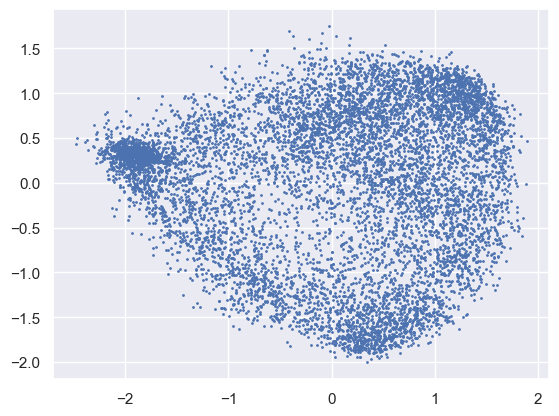

In [21]:
visualizar_embeddings_basico(embeddings, title="Visualização simples dos Embeddings")

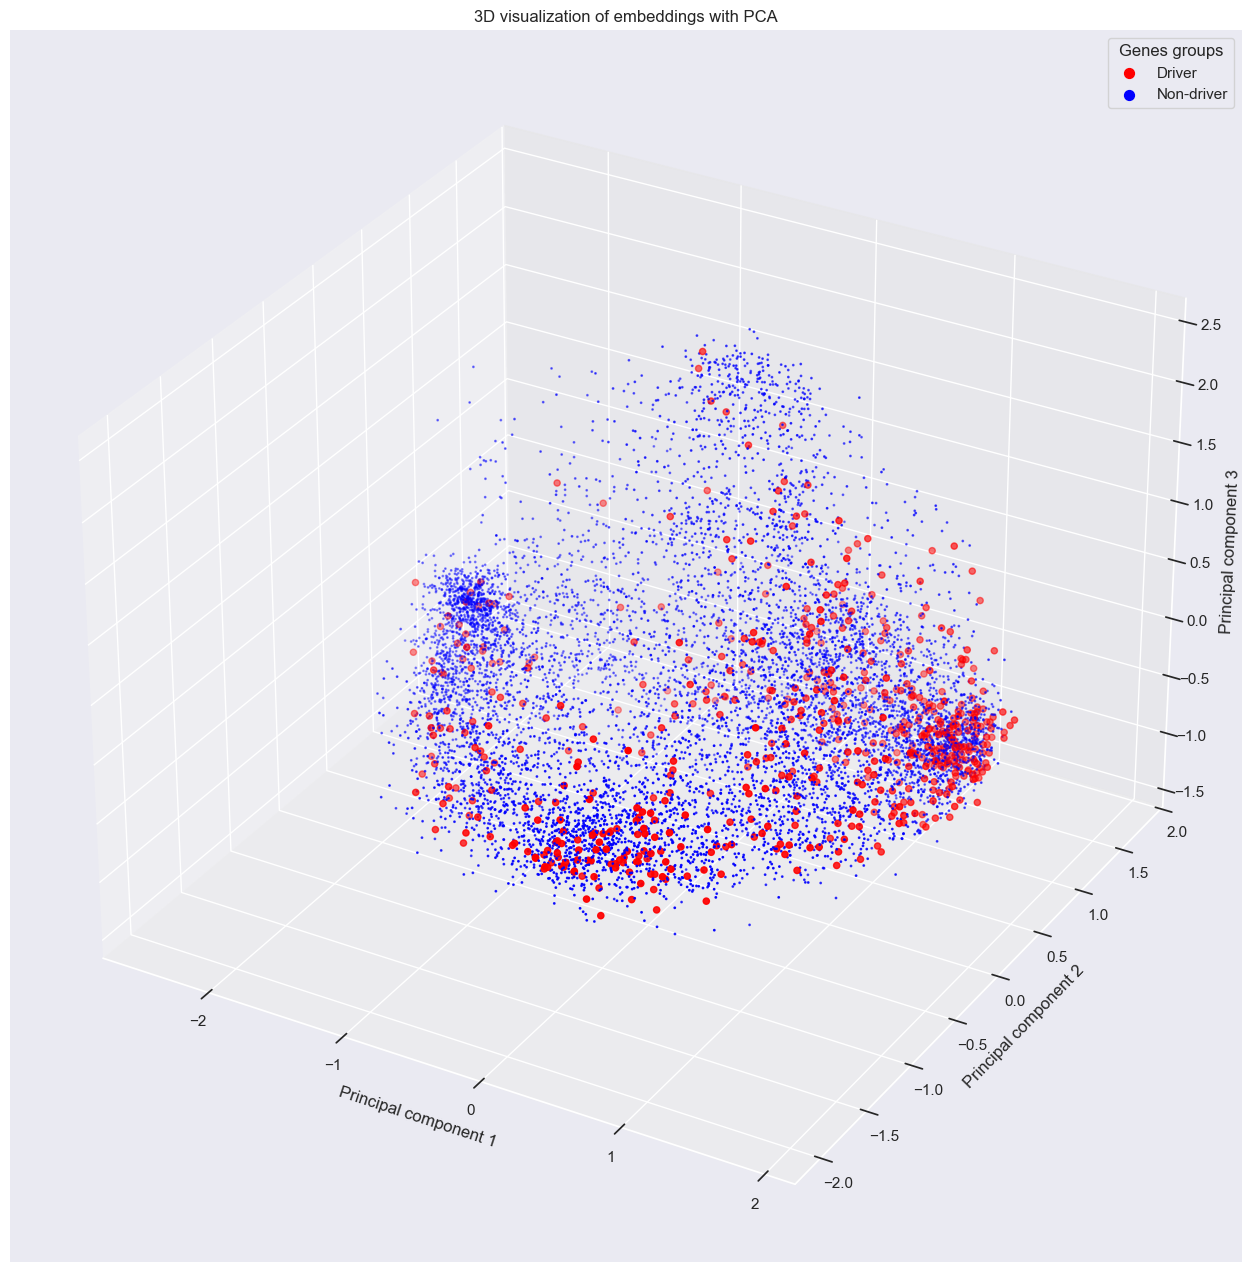

In [22]:
embeddings = {str(gene): modelo.wv[str(gene)] for gene in G.nodes()}  # Embeddings gerados pelo node2vec
gene_names = list(G.nodes())  # Lista de nomes dos genes
highlight_genes = cgc_list  # Lista de genes *drivers* para destacar

# Chama a função para visualizar os embeddings
visualizar_embeddings_3d(
    embeddings=embeddings,
    gene_names=gene_names,
    highlight_genes=highlight_genes,
    title="3D visualization of embeddings with PCA",
    highlight_color='red',  # Cor para genes *drivers*
    default_color='blue',   # Cor para outros genes
    highlight_size=20,      # Tamanho dos pontos destacados
    default_size=1,         # Tamanho dos pontos não destacados
    figsize=(24, 16),       # Tamanho da figura
    save_path=FIG_BASE_PATH+'embedding_visualization_1.jpg'  # Salva a figura no caminho especificado
)


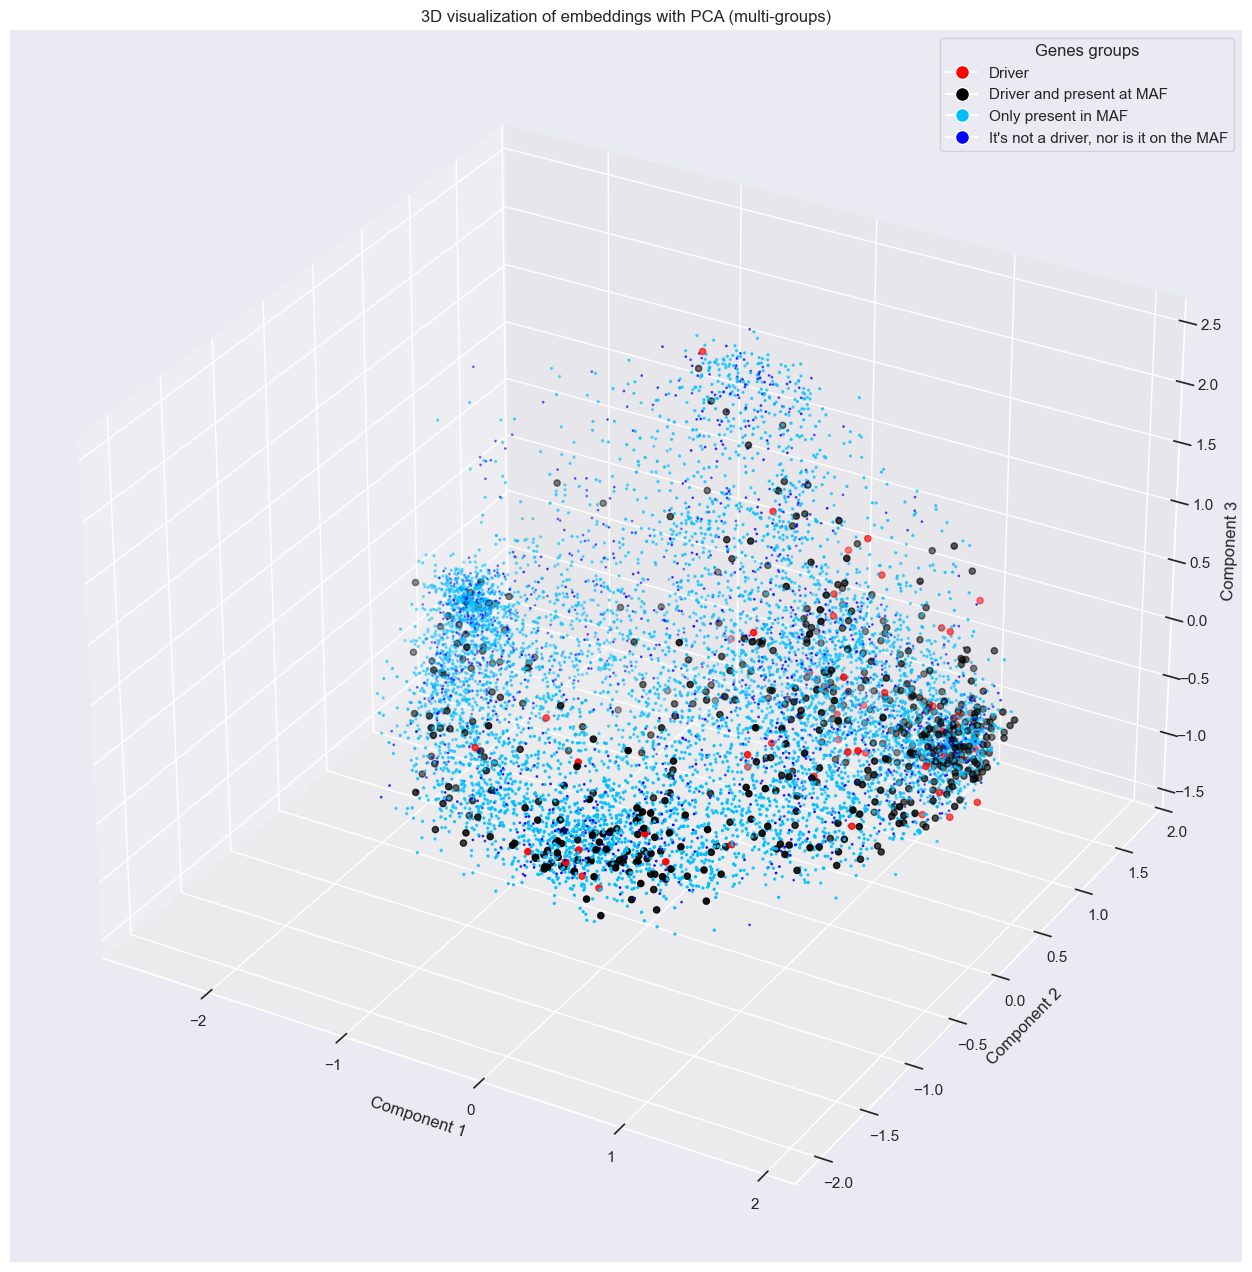

In [23]:
# Exemplo de uso
embeddings = {str(gene): modelo.wv[str(gene)] for gene in G.nodes()}  # Embeddings gerados pelo node2vec
gene_names = list(G.nodes())  # Lista de nomes dos genes
highlight_driver_genes = cgc_list  # Lista de genes *drivers* para destacar
highlight_maf_genes = maf_list  # Lista de genes presentes no MAF para destacar

# Chama a função para visualizar os embeddings
visualizar_embeddings_3d_multigrupos(
    embeddings=embeddings,
    gene_names=gene_names,
    highlight_driver_genes=highlight_driver_genes,
    highlight_maf_genes=highlight_maf_genes,
    title="3D visualization of embeddings with PCA (multi-groups)",
    driver_color='red',          # Cor para genes *drivers*
    driver_maf_color='black',    # Cor para genes *drivers* presentes no MAF
    maf_color='deepskyblue',     # Cor para genes presentes apenas no MAF
    default_color='blue',        # Cor para outros genes
    driver_size=20,              # Tamanho dos pontos para genes *drivers*
    maf_size=2,                  # Tamanho dos pontos para genes presentes no MAF
    default_size=1,              # Tamanho dos pontos para outros genes
    figsize=(24, 16),            # Tamanho da figura
    save_path=FIG_BASE_PATH+'embedding_visualization_2.jpg'  # Salva a figura no caminho especificado
)

### 5. verifique se existem algumas regiões específicas onde tem uma densidade maior dos drivers. O ideal é que tenha regiões onde tem mais concentração desses genes drivers.

Nesta etapa, precisamos verificar se existem áreas específicas no espaço de embeddings onde os genes drivers estão mais concentrados. Podemos fazer isso usando uma combinação de clustering baseado em densidade (DBSCAN) e visualização de densidade (KDE).

#### 5.1 Considerando todos os drivers do CGC

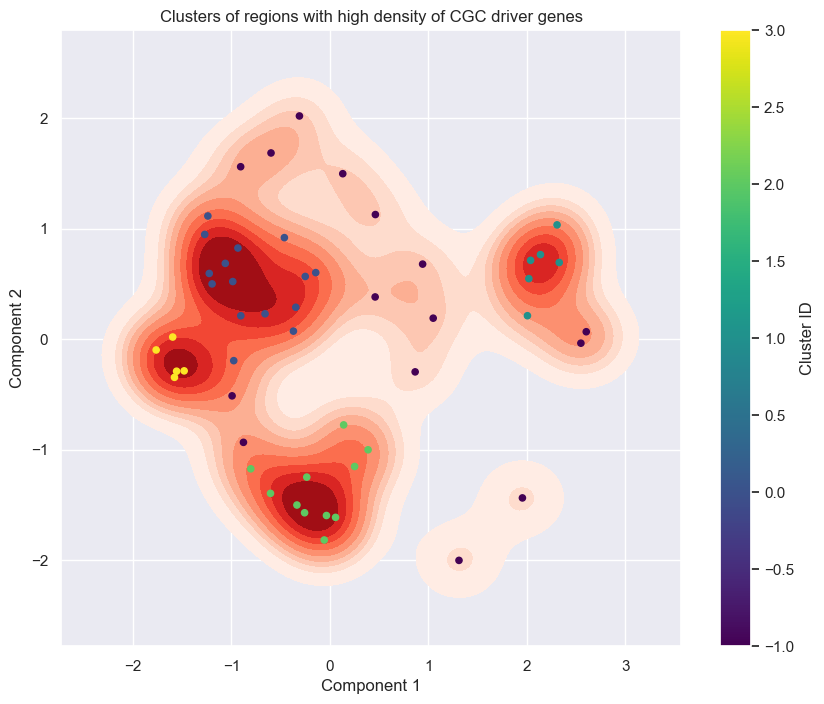

In [24]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

genes_names = list(G.nodes)
highlight_driver_genes_cgc = cgc_list  # Exemplo de genes que deseja destacar
highlight_genes_maf = maf_list
colors = ['black' if (gene in highlight_driver_genes_cgc and gene in highlight_genes_maf) else 'red' if gene in highlight_driver_genes_cgc else 'deepskyblue' if gene in highlight_genes_maf else 'blue' for gene in gene_names]

clusters_drivers_cgc, reduced_drivers_embeddings_2d = visualize_drivers_clustering(embeddings=modelo.wv,
                                                                                   colors=colors,
                                                                                   driver_color='red',
                                                                                   eps=0.5,
                                                                                   min_samples=5,
                                                                                   title="Clusters of regions with high density of CGC driver genes",
                                                                                   figsize=(10, 8),
                                                                                   save_path=FIG_BASE_PATH+'densidade_genes_drivers.jpg')


#### 5.2 Considerando todos os drivers do CGC que estão no MAF

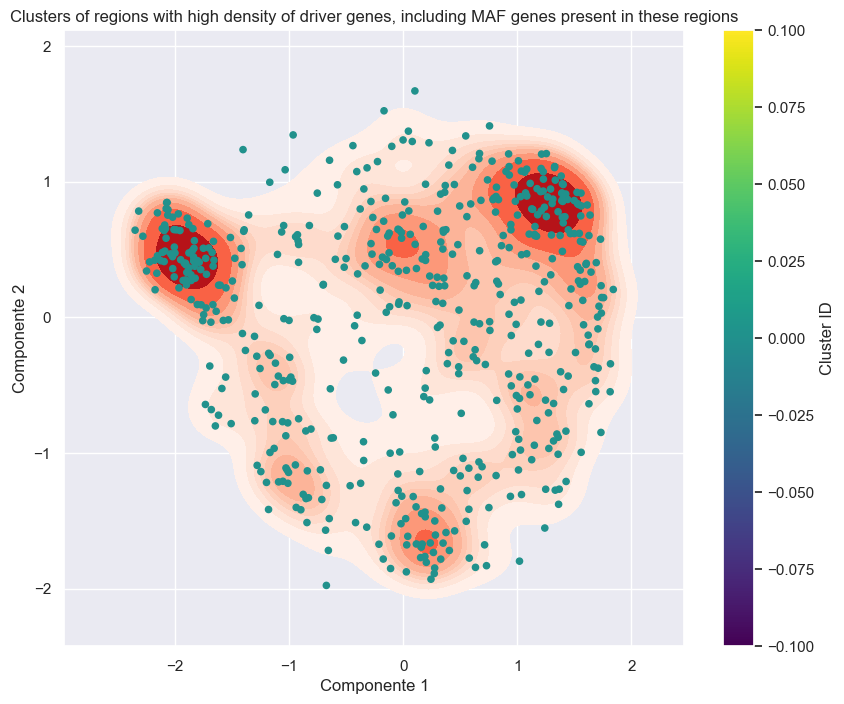

In [25]:
genes_names = list(G.nodes)
highlight_driver_genes_cgc = cgc_list  # Exemplo de genes que deseja destacar
highlight_genes_maf = maf_list
colors = ['black' if (gene in highlight_driver_genes_cgc and gene in highlight_genes_maf) else 'red' if gene in highlight_driver_genes_cgc else 'deepskyblue' if gene in highlight_genes_maf else 'blue' for gene in gene_names]

clusters_drivers_cgc_maf = visualize_clustering_by_color(
    embeddings=modelo.wv,
    colors=colors,
    target_color='black',
    eps=0.5,
    min_samples=5,
    title="Clusters of regions with high density of driver genes, including MAF genes present in these regions",
    figsize=(10, 8),
    save_path=FIG_BASE_PATH+'densidade_genes_drives_cgc_maf_clustering.jpg'
)


### 6. se existem tais regiões, pega todos os outros genes NÃO drivers nessas regiões e faça uma análise completa das suas características que podem ser características biológicas (tipo de proteína, ...) ou até as suas características na rede (suas conexões, ...).


Aqui peguei apenas os genes do MAF que não são drivers, porém estão nessas regiões com alta densidade de genes drivers do CGC que não foram encontrados no MAF

In [26]:
# Supondo que você já tenha os embeddings, gene_names, e highlight_genes definidos
embeddings_matrix = [embeddings[str(gene)] for gene in G.nodes]

df_analise = analisar_genes_nao_drivers_em_regioes_drivers(embeddings_matrix, gene_names, cgc_list, eps=0.5, min_samples=5)

# Exibir o DataFrame com as características dos genes não drivers


# Ordenando em ordem decrescente
df_analise = df_analise.sort_values(by='Conexões_na_Rede', ascending=False)
df_analise

,Gene,Conexões_na_Rede
2,PTCH2,4
0,IHH,3
23,HHIP,3
19,APOBEC1,3
8,SHH,3
16,DHH,3
1,FOXP4,2
26,MSTN,2
22,HLA-DPA1,2
20,LGALS1,2


In [27]:
maf_df

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode
1384,ZBTB48,1,6646027,6646027,Silent,SNP,T,C,TCGA-B7-5818-01
1385,VPS13D,1,12336395,12336395,Missense_Mutation,SNP,T,G,TCGA-B7-5818-01
1386,KIF17,1,21031296,21031296,Missense_Mutation,SNP,C,T,TCGA-B7-5818-01
1387,EIF4G3,1,21177780,21177780,Missense_Mutation,SNP,T,G,TCGA-B7-5818-01
1388,FHL3,1,38465047,38465047,Missense_Mutation,SNP,G,A,TCGA-B7-5818-01
...,...,...,...,...,...,...,...,...,...
148515,CUBN,10,17165610,17165611,Frame_Shift_Ins,INS,-,A,TCGA-IN-8663-01
148516,ZNF267,16,31926652,31926653,Frame_Shift_Ins,INS,-,T,TCGA-IN-8663-01
148517,ADCY3,2,25045416,25045417,Frame_Shift_Ins,INS,-,G,TCGA-IP-7968-01
148518,FOSL2,2,28627223,28627224,Frame_Shift_Ins,INS,-,C,TCGA-IP-7968-01


#### Aqui peguei apenas os genes do MAF que não são drivers, porém estão nessas regiões com alta densidade de genes drivers do CGC e que também foram encontrados no MAF
#### Obtive os mesmos valores encontrados em df_analise, mas fiz apenas pra confirmar.

In [28]:
df_filtrado = df_analise[df_analise['Gene'].isin(maf_df['Hugo_Symbol'])]
df_filtrado

,Gene,Conexões_na_Rede
2,PTCH2,4
0,IHH,3
23,HHIP,3
19,APOBEC1,3
8,SHH,3
16,DHH,3
1,FOXP4,2
26,MSTN,2
22,HLA-DPA1,2
20,LGALS1,2


### 7. tenta identificar as características em comuns entre esses outros genes, proteínas, ... que ficam nessas regiões próximas onde há uma densidade maior dos drivers.

In [29]:
features_df = pd.read_parquet('../features.parquet')
features_df.head()

,Gene,DegreeCentrality,BetweennessCentrality,ClosenessCentrality,MutationCount,MutationRate,Intogen,FalsePositives,isDriver
0,CHRNA1,0.000332,7.346063e-08,0.000332,5.0,0.006289,0,0,0
1,CHRNE,0.000111,0.000000e+00,0.000199,0.0,0.000000,0,0,0
2,CHRNG,0.000111,0.000000e+00,0.000199,3.0,0.003774,0,0,0
3,CHRND,0.000111,0.000000e+00,0.000199,3.0,0.003774,0,0,0
4,FHL2,0.000885,4.012942e-04,0.202172,1.0,0.001258,0,0,0


#### 7.1 Extração das características topológicas dos genes vizinhos de genes drivers no espaço de embeddings.

In [30]:
df_analise['vizinho'] = 1

In [31]:
merged_df = pd.merge(df_analise, features_df, on='Gene', how='right')
merged_df['vizinho'] = merged_df['vizinho'].fillna(0).astype(int)
merged_df['Conexões_na_Rede'] = merged_df['Conexões_na_Rede'].fillna(0).astype(int)

In [32]:
merged_df

,Gene,Conexões_na_Rede,vizinho,DegreeCentrality,BetweennessCentrality,ClosenessCentrality,MutationCount,MutationRate,Intogen,FalsePositives,isDriver
0,CHRNA1,0,0,0.000332,7.346063e-08,0.000332,5.0,0.006289,0,0,0
1,CHRNE,0,0,0.000111,0.000000e+00,0.000199,0.0,0.000000,0,0,0
2,CHRNG,0,0,0.000111,0.000000e+00,0.000199,3.0,0.003774,0,0,0
3,CHRND,0,0,0.000111,0.000000e+00,0.000199,3.0,0.003774,0,0,0
4,FHL2,0,0,0.000885,4.012942e-04,0.202172,1.0,0.001258,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9034,TSPO,0,0,0.000221,2.448688e-08,0.000221,0.0,0.000000,0,0,0
9035,DBI,0,0,0.000111,0.000000e+00,0.000148,0.0,0.000000,0,0,0
9036,BZRAP1,0,0,0.000111,0.000000e+00,0.000148,9.0,0.011321,0,0,0
9037,SLC1A4,0,0,0.000111,0.000000e+00,0.000148,2.0,0.002516,0,0,0


In [33]:
merged_df[merged_df['Conexões_na_Rede'] != 0]

,Gene,Conexões_na_Rede,vizinho,DegreeCentrality,BetweennessCentrality,ClosenessCentrality,MutationCount,MutationRate,Intogen,FalsePositives,isDriver
4246,GLUD1,1,1,0.000111,0.000000e+00,0.000306,1.0,0.001258,0,0,0
4607,HLA-DPA1,2,1,0.000221,0.000000e+00,0.000249,0.0,0.000000,0,0,0
4608,HLA-DPB1,2,1,0.000221,0.000000e+00,0.000249,3.0,0.003774,0,0,0
4888,MSTN,2,1,0.000221,2.448688e-08,0.000221,3.0,0.003774,0,0,0
4890,WFIKKN2,1,1,0.000111,0.000000e+00,0.000148,3.0,0.003774,0,0,0
5012,LGALS1,2,1,0.000221,9.794750e-08,0.000295,5.0,0.006289,0,0,0
5750,WNT7B,2,1,0.000221,2.062774e-04,0.070436,0.0,0.000000,0,0,0
5824,HLA-DOA,1,1,0.000111,0.000000e+00,0.000373,1.0,0.001258,0,0,0
5825,HLA-DOB,1,1,0.000111,0.000000e+00,0.000337,0.0,0.000000,0,0,0
6327,CDH12,2,1,0.000221,8.162292e-09,0.000332,7.0,0.008805,0,1,0


### Criando uma coluna de classe, sendo 3 tipos de classes.
#### 1. É um vizinho de um driver.
#### 2. É um driver.
#### 3. Não é um vizinho e não é um driver

In [34]:
merged_df['Classe'] = merged_df.apply(lambda row: 1 if row['vizinho'] == 1 else 2 if row['vizinho'] == 0 and row['isDriver'] == 1 else  3, axis=1)

In [35]:
merged_df

,Gene,Conexões_na_Rede,vizinho,DegreeCentrality,BetweennessCentrality,ClosenessCentrality,MutationCount,MutationRate,Intogen,FalsePositives,isDriver,Classe
0,CHRNA1,0,0,0.000332,7.346063e-08,0.000332,5.0,0.006289,0,0,0,3
1,CHRNE,0,0,0.000111,0.000000e+00,0.000199,0.0,0.000000,0,0,0,3
2,CHRNG,0,0,0.000111,0.000000e+00,0.000199,3.0,0.003774,0,0,0,3
3,CHRND,0,0,0.000111,0.000000e+00,0.000199,3.0,0.003774,0,0,0,3
4,FHL2,0,0,0.000885,4.012942e-04,0.202172,1.0,0.001258,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9034,TSPO,0,0,0.000221,2.448688e-08,0.000221,0.0,0.000000,0,0,0,3
9035,DBI,0,0,0.000111,0.000000e+00,0.000148,0.0,0.000000,0,0,0,3
9036,BZRAP1,0,0,0.000111,0.000000e+00,0.000148,9.0,0.011321,0,0,0,3
9037,SLC1A4,0,0,0.000111,0.000000e+00,0.000148,2.0,0.002516,0,0,0,3


In [36]:
teste = merged_df.drop(['vizinho', 'Intogen', 'FalsePositives', 'FalsePositives', 'isDriver'], axis=1).columns
teste

Index(['Gene', 'Conexões_na_Rede', 'DegreeCentrality', 'BetweennessCentrality',
       'ClosenessCentrality', 'MutationCount', 'MutationRate', 'Classe'],
      dtype='object')

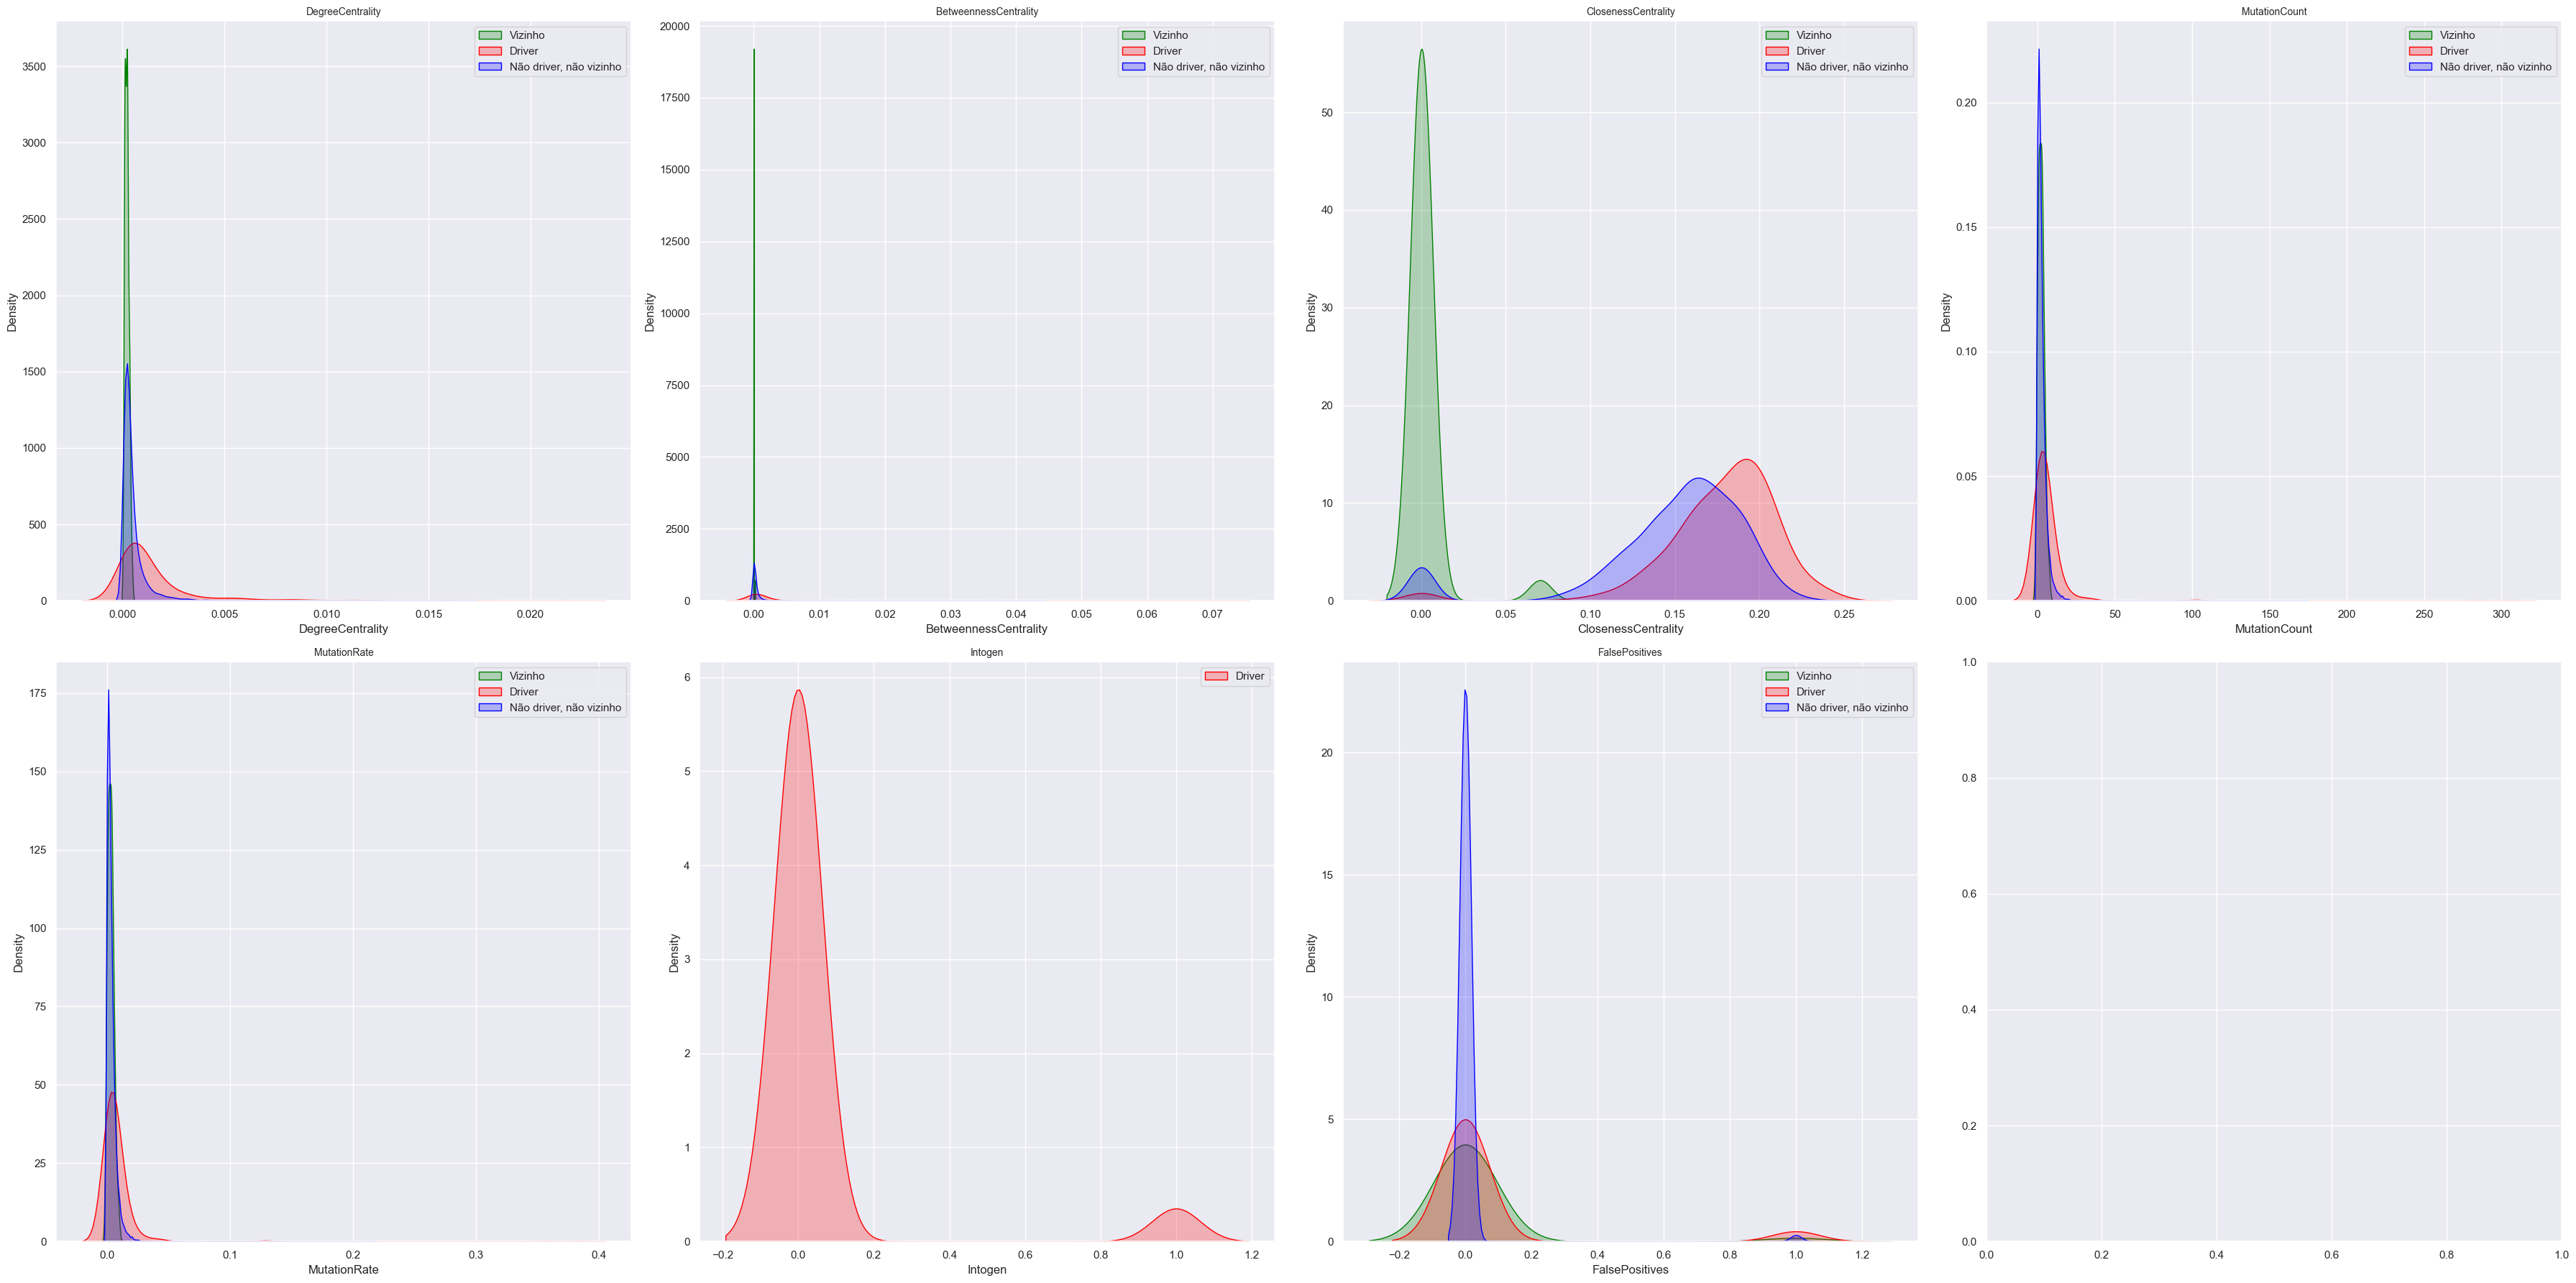

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona apenas colunas numéricas para evitar o erro
column_names = merged_df.drop(['Conexões_na_Rede', 'vizinho', 'isDriver', 'Classe'], axis=1).select_dtypes(include=['number']).columns

num_plots = len(column_names)

# Cria um dataframe para cada classe
df_class_1 = merged_df[merged_df.Classe == 1]
df_class_2 = merged_df[merged_df.Classe == 2]
df_class_3 = merged_df[merged_df.Classe == 3]  # Corrigido (antes estava == 2)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(36, 18))
fig.subplots_adjust(hspace=1, wspace=1)

# Plot das distribuições
idx = 0
for col in column_names:
    idx += 1
    plt.subplot(2, 4, idx)
    
    # Plota apenas se a coluna estiver no DataFrame e for numérica
    if col in df_class_1 and col in df_class_2 and col in df_class_3:
        sns.kdeplot(df_class_1[col].dropna(), fill=True, label='Vizinho', color='green')
        sns.kdeplot(df_class_2[col].dropna(), fill=True, label='Driver', color='red')
        sns.kdeplot(df_class_3[col].dropna(), fill=True, label='Não driver, não vizinho', color='blue')

        plt.title(col, fontsize=10)
        plt.legend()
    
plt.tight_layout()
plt.savefig(FIG_BASE_PATH+'kde.png')
plt.show()


In [38]:
merge_df_pearson = merged_df.drop(['Gene','Conexões_na_Rede', 'vizinho', 'isDriver', 'Classe'], axis=1)

In [39]:
merge_df_pearson.corr(method='pearson')

,DegreeCentrality,BetweennessCentrality,ClosenessCentrality,MutationCount,MutationRate,Intogen,FalsePositives
DegreeCentrality,1.000000,0.801936,0.330854,0.156089,0.156089,0.200741,0.017215
BetweennessCentrality,0.801936,1.000000,0.219108,0.225969,0.225969,0.185733,0.011973
ClosenessCentrality,0.330854,0.219108,1.000000,0.063205,0.063205,0.063875,0.031695
MutationCount,0.156089,0.225969,0.063205,1.000000,1.000000,0.382263,0.177954
MutationRate,0.156089,0.225969,0.063205,1.000000,1.000000,0.382263,0.177954
Intogen,0.200741,0.185733,0.063875,0.382263,0.382263,1.000000,0.021304
FalsePositives,0.017215,0.011973,0.031695,0.177954,0.177954,0.021304,1.000000


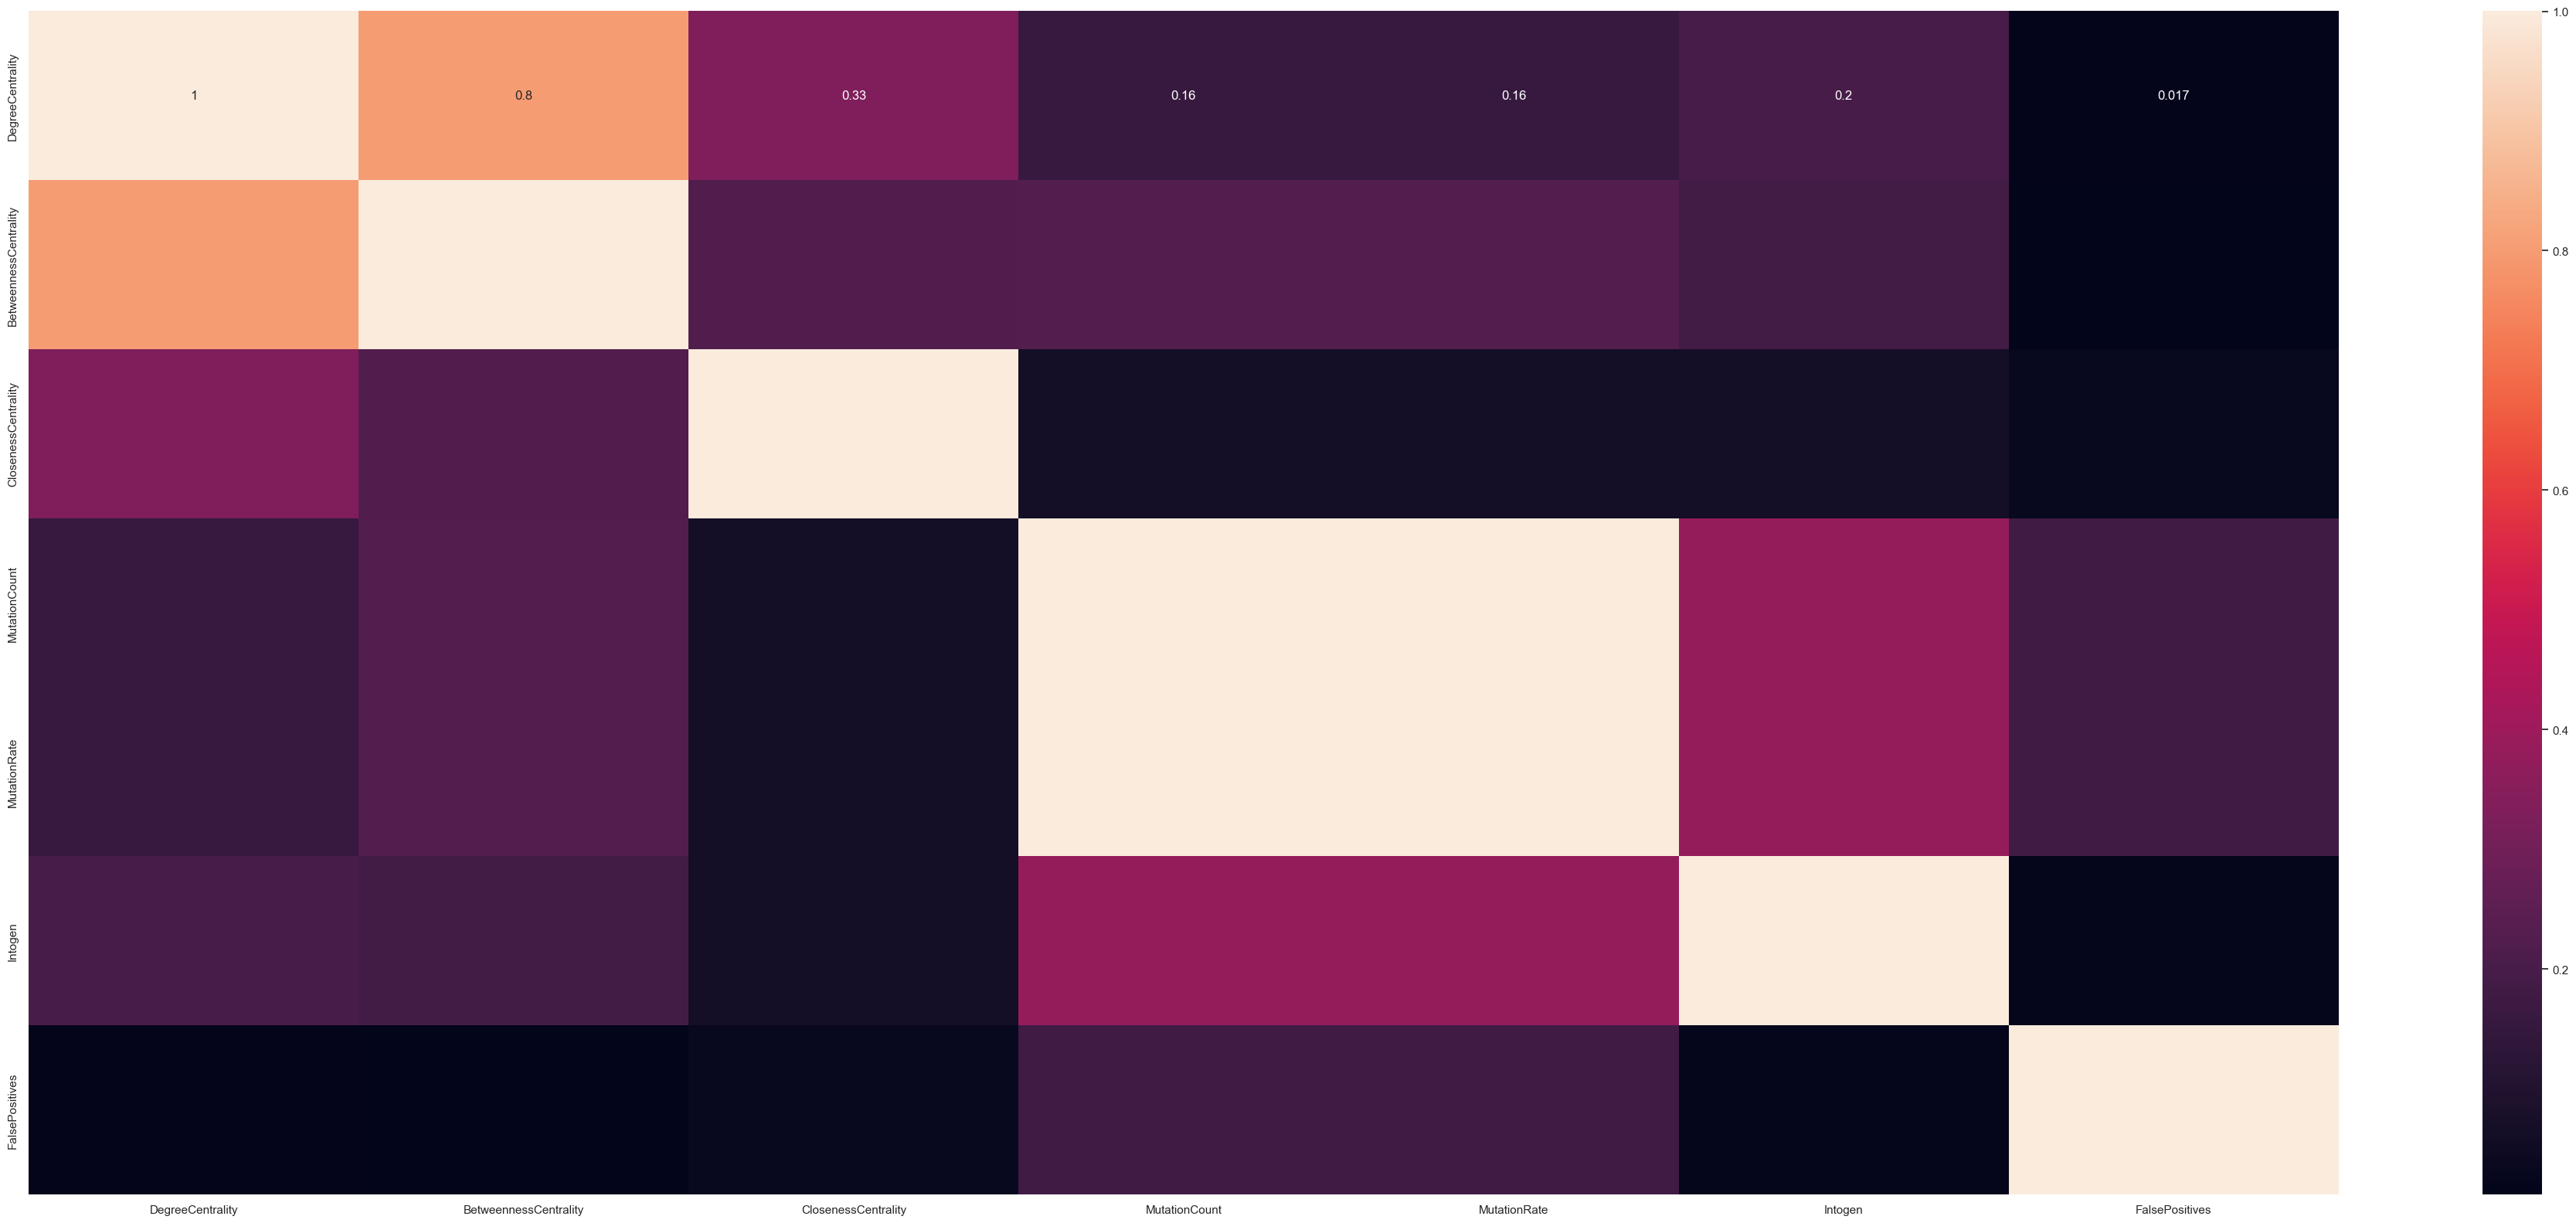

In [40]:
plt.figure(figsize = (38,16))
sns.heatmap(merge_df_pearson.corr(method='pearson'), annot = True)
plt.tight_layout()
plt.savefig(FIG_BASE_PATH+'heatmap.png')
plt.show()

### 7.2. Análise Estatística das Características dos Genes Não Drivers por Gene Driver

Comparar as características dos genes não drivers agrupados por seus respectivos genes drivers.
    
Estatísticas descritivas das características dos genes não drivers agrupados por gene driver

- O método groupby('Gene driver') agrupa os genes não drivers por seus respectivos genes drivers.
- As estatísticas descritivas ajudam a entender a distribuição das características dentro dos grupos.
  
**saida**: Estatísticas descritivas das características dos genes não drivers agrupados por gene driver

In [41]:
# Estatísticas descritivas agrupadas pelo gene driver
grouped_stats = merged_df.groupby('isDriver')[['DegreeCentrality', 'BetweennessCentrality', 'ClosenessCentrality', 'MutationRate']].describe()

# Exibir as estatísticas descritivas
print("Estatísticas descritivas das características dos genes não drivers agrupados por gene driver:")
grouped_stats

Estatísticas descritivas das características dos genes não drivers agrupados por gene driver:


DegreeCentrality                                                    \
                    count      mean       std       min       25%       50%   
isDriver                                                                      
0                  8435.0  0.000527  0.000846  0.000111  0.000111  0.000332   
1                   604.0  0.001564  0.002509  0.000111  0.000332  0.000775   

                             BetweennessCentrality            ...  \
               75%       max                 count      mean  ...   
isDriver                                                      ...   
0         0.000553  0.016929                8435.0  0.000402  ...   
1         0.001549  0.021576                 604.0  0.001659  ...   

         ClosenessCentrality           MutationRate                           \
                         75%       max        count      mean       std  min   
isDriver                                                                       
0                   0.178061  0.236397       8435.0  0.003252  0.004593  0.0   
1                   0.198749  0.247614        604.0  0.008118  0.024294  0.0   

                                                  
               25%       50%       75%       max  
isDriver                                          
0         0.001258  0.002516  0.003774  0.217610  
1         0.002516  0.003774  0.007547  0.384906  

[2 rows x 32 columns]

### 7.3. Identificar Genes Não Drivers com Valores Extremos
Encontrar genes não drivers com valores extremos de centralidade ou taxa de mutação.

Limiares baseados nos percentis (95%) ajudam a identificar valores atípicos.

Esses genes podem ser de interesse para estudos adicionais.

**Saída**: "Genes não drivers com valores extremos de centralidade ou taxa de mutação:"

In [42]:
# Definir limiares para valores extremos
degree_threshold = merged_df['DegreeCentrality'].quantile(0.95)
mutation_threshold = merged_df['MutationRate'].quantile(0.95)

# Filtrar genes não drivers com valores extremos
extreme_genes = merged_df[
    (merged_df['DegreeCentrality'] > degree_threshold) |
    (merged_df['MutationRate'] > mutation_threshold)
]

# Exibir os genes com valores extremos
extreme_genes[['isDriver', 'Gene', 'DegreeCentrality', 'MutationRate']]

,isDriver,Gene,DegreeCentrality,MutationRate
5,1,AR,0.012392,0.008805
9,1,CTNNB1,0.008409,0.005031
10,1,FOXO1,0.002213,0.000000
11,0,SRF,0.004315,0.003774
20,0,MED15,0.000553,0.022642
...,...,...,...,...
8957,0,SRPR,0.000221,0.011321
8978,1,POLG,0.000111,0.011321
9005,0,KCNH1,0.000221,0.011321
9032,0,KNTC1,0.000111,0.012579


In [43]:
extreme_genes

,Gene,Conexões_na_Rede,vizinho,DegreeCentrality,BetweennessCentrality,ClosenessCentrality,MutationCount,MutationRate,Intogen,FalsePositives,isDriver,Classe
5,AR,0,0,0.012392,2.537837e-02,0.240509,7.0,0.008805,0,0,1,2
9,CTNNB1,0,0,0.008409,2.120612e-02,0.235758,4.0,0.005031,0,0,1,2
10,FOXO1,0,0,0.002213,1.254645e-03,0.218203,0.0,0.000000,0,0,1,2
11,SRF,0,0,0.004315,4.352247e-03,0.208412,3.0,0.003774,0,0,0,3
20,MED15,0,0,0.000553,4.984222e-04,0.193959,18.0,0.022642,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
8957,SRPR,0,0,0.000221,2.448688e-08,0.000221,9.0,0.011321,0,0,0,3
8978,POLG,0,0,0.000111,0.000000e+00,0.108367,9.0,0.011321,0,0,1,2
9005,KCNH1,0,0,0.000221,2.693556e-07,0.000455,9.0,0.011321,0,0,0,3
9032,KNTC1,0,0,0.000111,0.000000e+00,0.000148,10.0,0.012579,0,0,0,3


### 7.4. Análise de Correlação entre Genes Drivers e seus Vizinhos
Calcular a correlação das características dos genes não drivers com os genes drivers.

A correlação revela relações entre as características dos genes drivers e seus vizinhos, ajudando a entender padrões compartilhados.

**Saída**: Correlação entre características dos genes drivers e seus vizinhos

In [44]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# Função para calcular a correlação entre os embeddings de dois genes
def calcular_correlacao(embedding1, embedding2):
    return pearsonr(embedding1, embedding2)[0]

# Função para encontrar os vizinhos de um gene na rede
def encontrar_vizinhos(gene, G):
    return list(G.neighbors(gene))

# Lista para armazenar os resultados
resultados_correlacao = []

# Iterar sobre os genes drivers
for gene_driver in cgc_list:
    if gene_driver in G.nodes:
        # Obter o embedding do gene driver
        embedding_driver = embeddings[str(gene_driver)]
        
        # Encontrar os vizinhos do gene driver
        vizinhos = encontrar_vizinhos(gene_driver, G)
        
        # Iterar sobre os vizinhos
        for vizinho in vizinhos:
            if str(vizinho) in embeddings:
                # Obter o embedding do vizinho
                embedding_vizinho = embeddings[str(vizinho)]
                
                # Calcular a correlação entre o gene driver e o vizinho
                correlacao = calcular_correlacao(embedding_driver, embedding_vizinho)
                
                # Armazenar o resultado
                resultados_correlacao.append({
                    'Gene_Driver': gene_driver,
                    'Vizinho': vizinho,
                    'Correlacao': correlacao
                })

# Converter os resultados em um DataFrame
df_correlacao = pd.DataFrame(resultados_correlacao)

# Exibir as primeiras linhas do DataFrame
print(df_correlacao.head())

# Análise estatística básica das correlações
print("\nEstatísticas das correlações:")
print(df_correlacao['Correlacao'].describe())

# Filtrar correlações significativas (por exemplo, correlação > 0.5)
correlacoes_significativas = df_correlacao[df_correlacao['Correlacao'] > 0.5]
print("\nCorrelações significativas (correlação > 0.5):")
print(correlacoes_significativas.head())

# Salvar os resultados em um arquivo CSV
df_correlacao.to_csv('correlacao_genes_drivers_vizinhos.csv', index=False)

  Gene_Driver  Vizinho  Correlacao
0        A1CF  APOBEC1    0.999677
1        A1CF    CELF2    0.999733
2        ABI1     NCF1    0.621781
3        ABI1    WASF1    0.738472
4        ABI1     VASP    0.678937

Estatísticas das correlações:
count    8539.000000
mean        0.669837
std         0.139841
min         0.230774
25%         0.570069
50%         0.666553
75%         0.769050
max         0.999733
Name: Correlacao, dtype: float64

Correlações significativas (correlação > 0.5):
  Gene_Driver  Vizinho  Correlacao
0        A1CF  APOBEC1    0.999677
1        A1CF    CELF2    0.999733
2        ABI1     NCF1    0.621781
3        ABI1    WASF1    0.738472
4        ABI1     VASP    0.678937


In [45]:
correlacoes_significativas[correlacoes_significativas['Correlacao'] != 0]

,Gene_Driver,Vizinho,Correlacao
0,A1CF,APOBEC1,0.999677
1,A1CF,CELF2,0.999733
2,ABI1,NCF1,0.621781
3,ABI1,WASF1,0.738472
4,ABI1,VASP,0.678937
...,...,...,...
8534,ZNRF3,GFI1B,0.923289
8535,ZRSR2,SRSF2,0.831440
8536,ZRSR2,U2AF2,0.860241
8537,ZRSR2,U2AF1,0.913601


# Explicação do código abaixo

### Nesta etapa, estou:
1. Pegando os genes vizinhos dos genes drivers na rede.  
2. Encontrando o gene driver e também os vizinhos no espaço de embeddings.  
3. Calculando a correlação entre cada driver e seu vizinho na rede no espaço de embeddings.  

**Importante:**  
- O gene vizinho é aquele que está conectado a um driver na rede.  
- A correlação é calculada com base na representação vetorial de cada par de genes (vizinho e driver).  

**Observação relevante:**  
Quando um par de genes (vizinho, driver) apresenta alta correlação, isso indica que, além de serem vizinhos na rede, eles possuem características topológicas muito semelhantes no espaço de embeddings, podendo ser fortes candidatos a drivers. É importante lembrar que a representação de um gene no espaço de embeddings não considera apenas seu vizinho direto, mas também toda a sua vizinhança local. Isso ocorre porque, aqui, considero um aspecto **local** do gene na rede para gerar cada embedding.

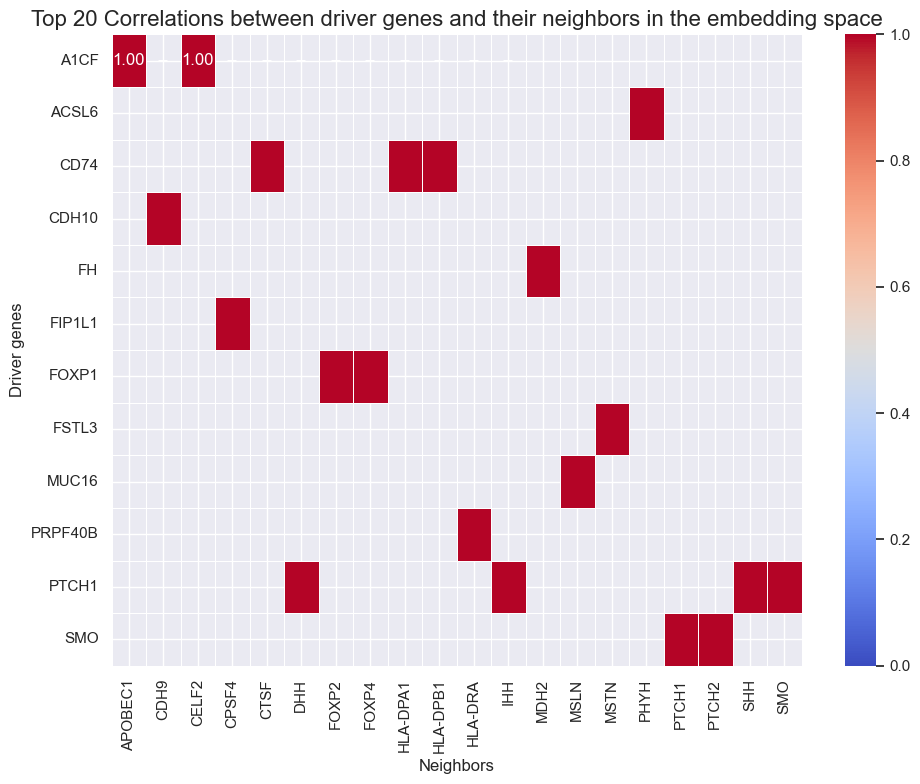

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ordenar as correlações em ordem decrescente e selecionar as top 20
top_n = 20
top_correlacoes = correlacoes_significativas.sort_values(by='Correlacao', ascending=False).head(top_n)

# Criar uma matriz de correlações entre genes drivers e seus vizinhos
correlation_matrix = top_correlacoes.pivot(index='Gene_Driver', columns='Vizinho', values='Correlacao')

# Configurar o tamanho da figura
plt.figure(figsize=(10, 8))

# Gerar o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', vmin=0, vmax=1)

# Adicionar título e rótulos
plt.title(f'Top {top_n} Correlations between driver genes and their neighbors in the embedding space', fontsize=16)
plt.xlabel('Neighbors', fontsize=12)
plt.ylabel('Driver genes', fontsize=12)

# Ajustar layout para melhorar a legibilidade
plt.tight_layout()

# Salvar a figura
plt.savefig(f'{FIG_BASE_PATH}top_{top_n}_correlacoes_drives_vizinhos.png', dpi=300, bbox_inches='tight')

# Exibir o gráfico
plt.show()

In [47]:
top_correlacoes

,Gene_Driver,Vizinho,Correlacao
1,A1CF,CELF2,0.999733
0,A1CF,APOBEC1,0.999677
105,ACSL6,PHYH,0.999624
1356,CD74,HLA-DPA1,0.999586
1357,CD74,HLA-DPB1,0.999571
3233,FOXP1,FOXP2,0.999563
3235,FSTL3,MSTN,0.999563
7282,SMO,PTCH1,0.999562
5989,PTCH1,SMO,0.999562
3127,FIP1L1,CPSF4,0.999537


### Aqui estou verificando se os genes com maiores correlações no espaço de embeddings entre genes não drivers e drivers são genes presentes no intogen
Resposta: Os genes com maior correlação com os genes driver no espaço de embeddings não estão no intogen, logo ter as mais altas correlações podem não necessariamente indicar que são um gene driver

In [48]:
intogen = pd.read_csv(INTOGEN_PATH, sep='\t')
top_correlacoes['Intogen'] = top_correlacoes['Vizinho'].isin(intogen['Symbol']).astype(int)

In [49]:
top_correlacoes

,Gene_Driver,Vizinho,Correlacao,Intogen
1,A1CF,CELF2,0.999733,0
0,A1CF,APOBEC1,0.999677,0
105,ACSL6,PHYH,0.999624,0
1356,CD74,HLA-DPA1,0.999586,0
1357,CD74,HLA-DPB1,0.999571,0
3233,FOXP1,FOXP2,0.999563,0
3235,FSTL3,MSTN,0.999563,0
7282,SMO,PTCH1,0.999562,0
5989,PTCH1,SMO,0.999562,0
3127,FIP1L1,CPSF4,0.999537,0


### Aqui estou verificando quais genes que tem correlação com genes driver no espaço de embeddings estão no intogen, para posteriormente eu ver se existe alguma relação entre nível de correlação entre um driver e não driver no espaço de embeddings que indicam que possa ser um driver

In [50]:
correlacoes_significativas
correlacoes_significativas['Intogen'] = correlacoes_significativas['Vizinho'].isin(intogen['Symbol']).astype(int)
correlacoes_significativas[correlacoes_significativas['Intogen'] == 1]

,Gene_Driver,Vizinho,Correlacao,Intogen
169,AKT1,PTEN,0.579961,1
279,APC,CTNNB1,0.535761,1
423,ARHGAP5,RHOA,0.665656,1
483,ATM,TP53,0.506935,1
515,ATR,TP53,0.511242,1
...,...,...,...,...
8263,VAV1,RHOA,0.560094,1
8339,WRN,TP53,0.537563,1
8386,XPO1,TOP2A,0.573159,1
8518,ZMYM2,SMAD4,0.575610,1


# Explicação do código abaixo

### Nesta etapa, estou:
1. Pegando os genes vizinhos dos genes drivers na rede.  
2. Encontrando o gene driver e também os vizinhos no espaço de embeddings.  
3. Calculando a correlação entre cada driver e seu vizinho na rede no espaço de embeddings.  

**Importante:**  
- O gene vizinho é aquele que está conectado a um driver na rede.  
- A correlação é calculada com base na representação vetorial de cada par de genes (vizinho e driver).  

**Observação relevante:**  
Quando um par de genes (vizinho, driver) apresenta alta correlação, isso indica que, além de serem vizinhos na rede, eles possuem características topológicas muito semelhantes no espaço de embeddings, podendo ser fortes candidatos a drivers. É importante lembrar que a representação de um gene no espaço de embeddings não considera apenas seu vizinho direto, mas também toda a sua vizinhança local. Isso ocorre porque, aqui, considero um aspecto **local** do gene na rede para gerar cada embedding.

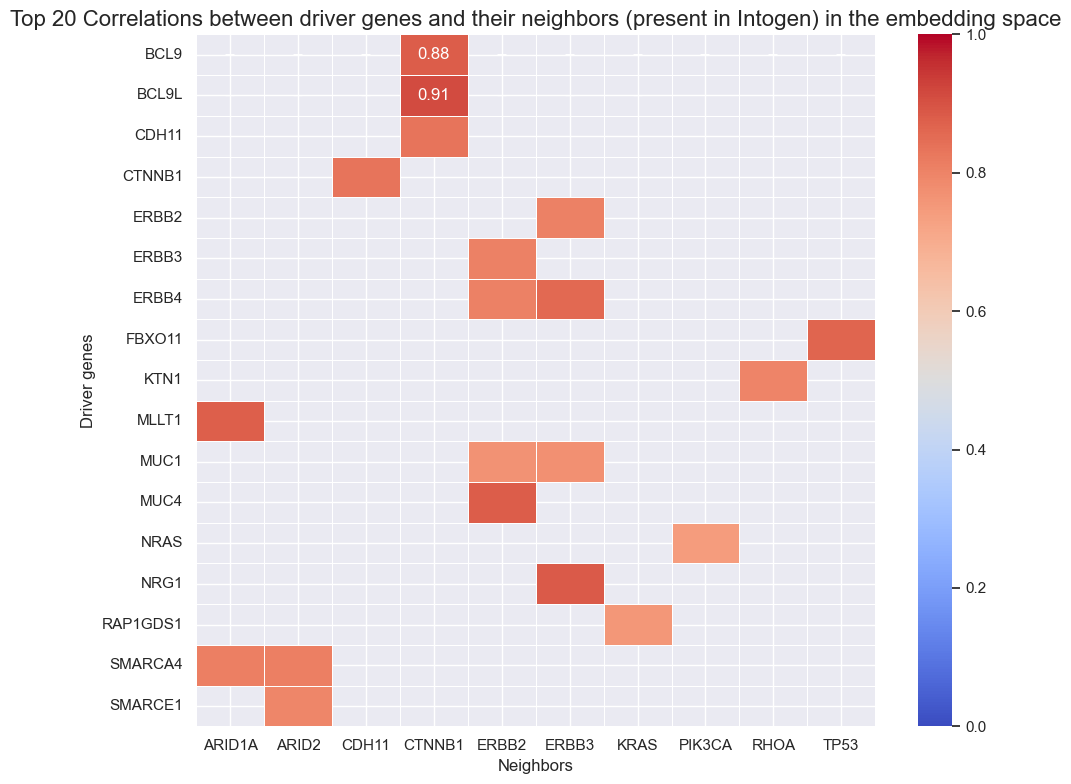

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ordenar as correlações em ordem decrescente e selecionar as top 20
top_n = 20
top_correlacoes = correlacoes_significativas[correlacoes_significativas['Intogen'] == 1].sort_values(by='Correlacao', ascending=False).head(top_n)

# Criar uma matriz de correlações entre genes drivers e seus vizinhos
correlation_matrix = top_correlacoes.pivot(index='Gene_Driver', columns='Vizinho', values='Correlacao')

# Configurar o tamanho da figura
plt.figure(figsize=(10, 8))

# Gerar o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', vmin=0, vmax=1)

# Adicionar título e rótulos
plt.title(f'Top {top_n} Correlations between driver genes and their neighbors (present in Intogen) in the embedding space', fontsize=16)
plt.xlabel('Neighbors', fontsize=12)
plt.ylabel('Driver genes', fontsize=12)

# Ajustar layout para melhorar a legibilidade
plt.tight_layout()

# Salvar a figura
plt.savefig(f'{FIG_BASE_PATH}top_{top_n}_correlacoes_drives_vizinhos_present_in_intogen.png', dpi=300, bbox_inches='tight')

# Exibir o gráfico
plt.show()

### Aqui estou criando um dataframe com os resultados obtidos no artigo do SBCAS, que são genes encontrados apenas usando redes enriquecidas, e que estão presentes no Intogen.

In [52]:
result_sbcas = pd.DataFrame({
    "Gene": ['KRAS', 'PTEN', 'ERBB2', 'SDC4'],
    "Probabilidade": [5.73, 3.21, 2.98, 0.92]
})

In [53]:
result_sbcas

,Gene,Probabilidade
0,KRAS,5.73
1,PTEN,3.21
2,ERBB2,2.98
3,SDC4,0.92


In [54]:
correlacoes_significativas

,Gene_Driver,Vizinho,Correlacao,Intogen
0,A1CF,APOBEC1,0.999677,0
1,A1CF,CELF2,0.999733,0
2,ABI1,NCF1,0.621781,0
3,ABI1,WASF1,0.738472,0
4,ABI1,VASP,0.678937,0
...,...,...,...,...
8534,ZNRF3,GFI1B,0.923289,0
8535,ZRSR2,SRSF2,0.831440,0
8536,ZRSR2,U2AF2,0.860241,0
8537,ZRSR2,U2AF1,0.913601,0


In [55]:
# Fazendo o merge entre os DataFrames com base em 'Gene' e 'Vizinho'
correlacao_sbcas = result_sbcas.merge(correlacoes_significativas, left_on='Gene', right_on='Vizinho', how='inner')
# Removendo a coluna duplicada Gene
correlacao_sbcas.drop(columns=['Gene'], inplace=True)
correlacao_sbcas = correlacao_sbcas.sort_values(by='Correlacao', ascending=False)

In [56]:
correlacao_sbcas

,Probabilidade,Gene_Driver,Vizinho,Correlacao,Intogen
10,2.98,MUC4,ERBB2,0.879140,1
6,2.98,ERBB4,ERBB2,0.807233,1
5,2.98,ERBB3,ERBB2,0.805906,1
9,2.98,MUC1,ERBB2,0.767882,1
2,5.73,RAP1GDS1,KRAS,0.755123,1
1,5.73,RALGDS,KRAS,0.738465,1
4,2.98,EGFR,ERBB2,0.702436,1
0,5.73,RAF1,KRAS,0.678296,1
16,0.92,CXCR4,SDC4,0.666501,1
14,2.98,PTPN11,ERBB2,0.664267,1


In [57]:
output_dict = {}

top_n = 20
top_correlacoes_sbcas = correlacao_sbcas[correlacao_sbcas['Intogen'] == 1].sort_values(by='Correlacao', ascending=False).head(top_n)


output_dict = {}
for _, row in top_correlacoes_sbcas.iterrows():
    vizinho = row["Vizinho"]
    gene_driver = row["Gene_Driver"]
    correlacao = row["Correlacao"]
    if vizinho not in output_dict:
        output_dict[vizinho] = []
    output_dict[vizinho].append(f"{gene_driver} ({correlacao:.2f})")

# Criando o texto formatado separado por ponto e vírgula e vizinho em \textbf{}
formatted_text = "; ".join([f"\\textbf{{{vizinho}}}: {', '.join(drivers)}" for vizinho, drivers in output_dict.items()])

print("Texto formatado:")
print(formatted_text)

Texto formatado:
\textbf{ERBB2}: MUC4 (0.88), ERBB4 (0.81), ERBB3 (0.81), MUC1 (0.77), EGFR (0.70), PTPN11 (0.66), JAK2 (0.64), NF2 (0.64), IL6ST (0.64), PIK3R1 (0.62), PLCG1 (0.62), SRC (0.58); \textbf{KRAS}: RAP1GDS1 (0.76), RALGDS (0.74), RAF1 (0.68); \textbf{SDC4}: CXCR4 (0.67); \textbf{PTEN}: AKT1 (0.58)


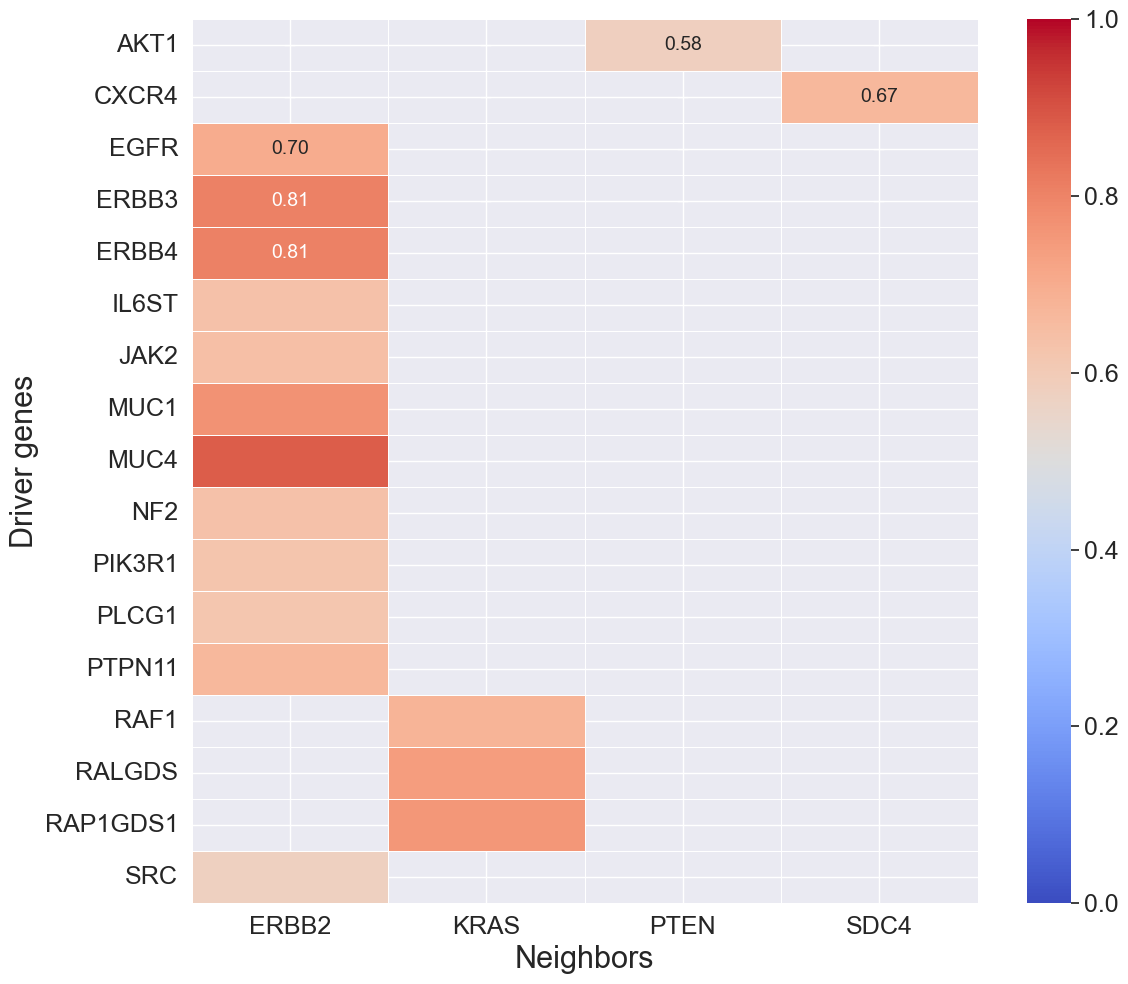

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ordenar as correlações em ordem decrescente e selecionar as top 20
top_n = 20
top_correlacoes = correlacao_sbcas[correlacao_sbcas['Intogen'] == 1].sort_values(by='Correlacao', ascending=False).head(top_n)

# Criar uma matriz de correlações entre genes drivers e seus vizinhos
correlation_matrix = top_correlacoes.pivot(index='Gene_Driver', columns='Vizinho', values='Correlacao')

# Configurar o tamanho da figura
plt.figure(figsize=(12, 10))

# Gerar o heatmap
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', vmin=0, vmax=1, annot_kws={"size": 18}, cbar_kws={"shrink": 0.8, "label": "Correlation", "labelsize": 18})
# Gerar o heatmap com tamanho de fonte maior para os valores anotados
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', vmin=0, vmax=1,
                      annot_kws={"size": 14},  # Tamanho da fonte dos valores anotados
                      cbar_kws={"shrink": 1.0})  # Configurações da barra de cores

# Acessar a barra de cores (colorbar) e ajustar o tamanho da fonte dos rótulos
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Ajuste o tamanho da fonte dos rótulos da barra de cores

# Adicionar título e rótulos
#plt.title(f'Top {top_n} Correlations between driver genes and their neighbors present in Intogen e and discovered in this thesis, in the embedding space', fontsize=16)
plt.xlabel('Neighbors', fontsize=22)
plt.ylabel('Driver genes', fontsize=22)

# Aumentar o tamanho da fonte dos rótulos dos eixos (nomes dos genes)
plt.xticks(fontsize=18)  # Ajuste o tamanho da fonte dos rótulos do eixo X
plt.yticks(fontsize=18)  # Ajuste o tamanho da fonte dos rótulos do eixo Y

# Ajustar layout para melhorar a legibilidade
plt.tight_layout()

# Salvar a figura
plt.savefig(f'{FIG_BASE_PATH}top_{top_n}_correlacoes_drives_vizinhos_present_in_intogen_and_sbcas.png', dpi=300, bbox_inches='tight')

# Exibir o gráfico
plt.show()

### 7.5. Visualizar o número de conexões na rede de genes não driver com genes drivers, no qual o gene não driver foi encontrado em um cluster de alta densidade de genes driver no espaço de embeddings.


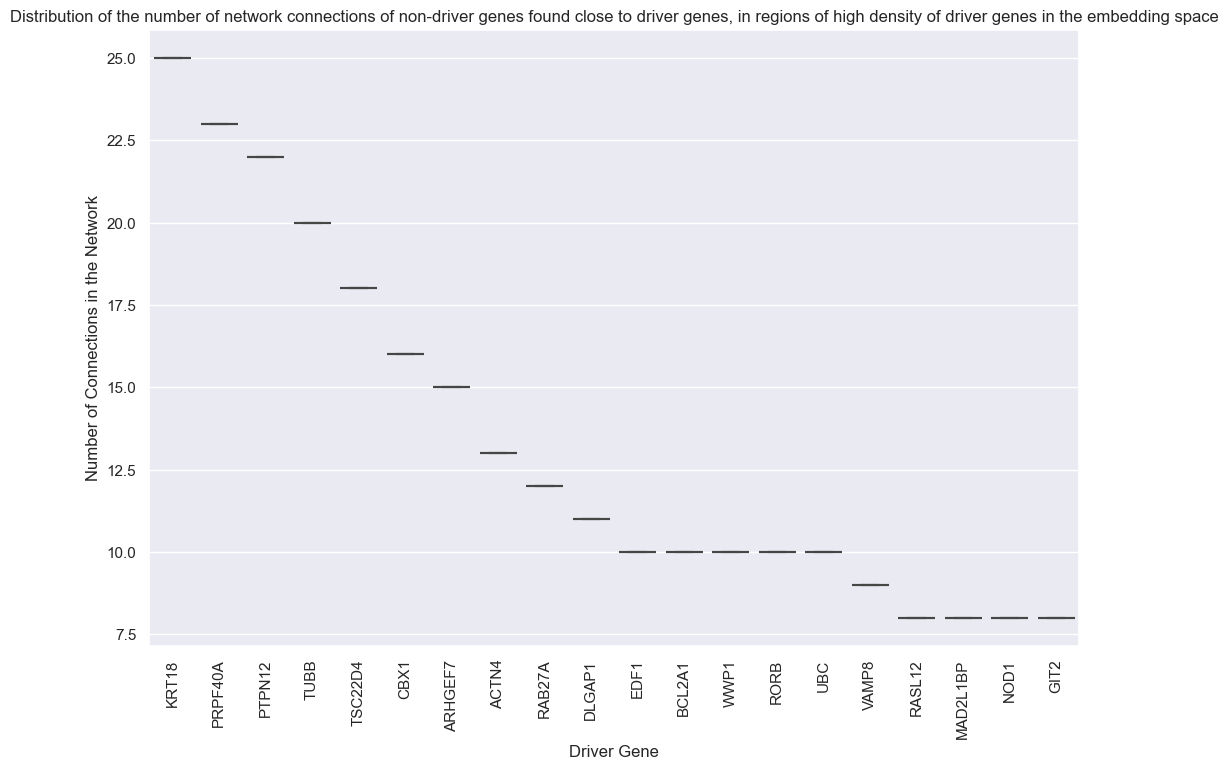

In [59]:
# Passo 1: Carregar os dados (se já não estiverem carregados)
# G, maf_df, cgc_list já devem estar carregados

# Passo 2: Gerar embeddings (se ainda não foi feito)
# modelo = gerar_embeddings(G, dimensions=64, walk_length=30, num_walks=200, workers=4, p=1, q=1)
embeddings = modelo.wv

# Passo 3: Identificar genes não drivers em regiões de genes drivers
df_genes_nao_drivers = analisar_genes_nao_drivers_em_regioes_drivers(embeddings, list(G.nodes), cgc_list)
df_genes_nao_drivers_top_20 = df_genes_nao_drivers.sort_values(by="Conexões_na_Rede", ascending=False).head(20)

# Passo 4: Criar gráficos de comparação usando boxplots
import seaborn as sns
import matplotlib.pyplot as plt

# Suponha que queremos comparar o número de conexões na rede para cada gene driver
plt.figure(figsize=(12, 8))
sns.boxplot(x='Gene', y='Conexões_na_Rede', data=df_genes_nao_drivers_top_20)
plt.title('Distribution of the number of network connections of non-driver genes found close to driver genes, in regions of high density of driver genes in the embedding space')
plt.xlabel('Driver Gene')
plt.ylabel('Number of Connections in the Network')
plt.xticks(rotation=90)
plt.savefig(f'{FIG_BASE_PATH}distribuition_of_number_connections_non_driver_and_driver', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
df_genes_nao_drivers.sort_values(by="Conexões_na_Rede", ascending=False).head(20)

,Gene,Conexões_na_Rede
110,KRT18,25
105,PRPF40A,23
70,PTPN12,22
64,TUBB,20
39,TSC22D4,18
44,CBX1,16
26,ARHGEF7,15
7,ACTN4,13
89,RAB27A,12
75,DLGAP1,11


### 7.6. Clustering dos Genes Não Drivers Agrupados por Gene Driver
Aplicar clustering para explorar padrões de agrupamento nas características dos genes não drivers em relação aos drivers.

- K-Means agrupa os genes não drivers com base em características semelhantes.
- A visualização dos clusters ajuda a identificar padrões específicos no espaço de características.

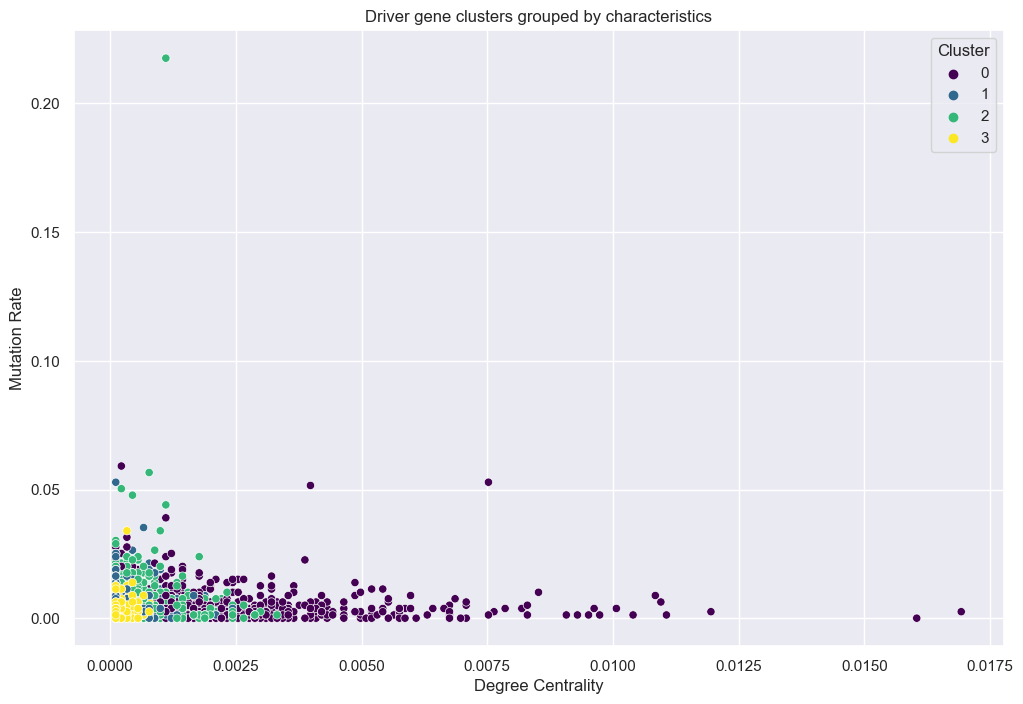

In [61]:
from sklearn.cluster import KMeans

merged_df_driver = merged_df[merged_df['isDriver'] == 0]

# Selecionar características dos genes não drivers
features_for_clustering = merged_df_driver[['DegreeCentrality', 'BetweennessCentrality', 'ClosenessCentrality', 'MutationRate']]

# Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
merged_df_driver['Cluster'] = kmeans.fit_predict(features_for_clustering)

# Visualizar clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df_driver, x='DegreeCentrality', y='MutationRate', hue='Cluster', palette='viridis')
plt.title('Driver gene clusters grouped by characteristics')
plt.xlabel('Degree Centrality')
plt.ylabel('Mutation Rate')
plt.legend(title='Cluster')
plt.savefig(f'{FIG_BASE_PATH}driver_gene_clusters_grouped_by_characteristics', dpi=300, bbox_inches='tight')
plt.show()


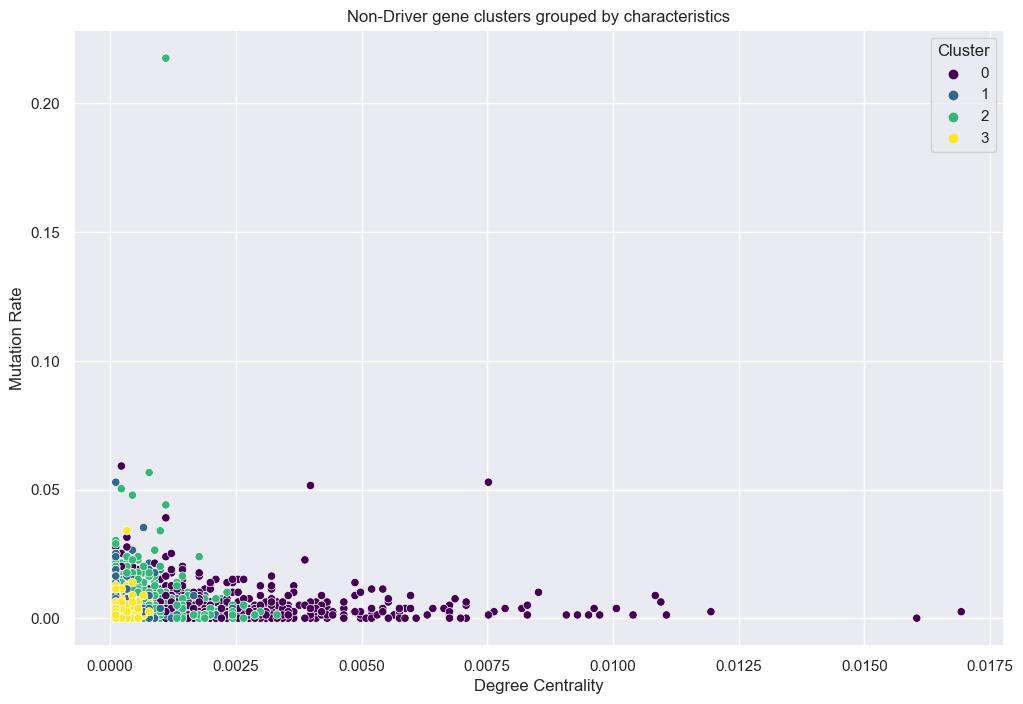

In [62]:
from sklearn.cluster import KMeans

merged_df_driver = merged_df[merged_df['isDriver'] == 0]

# Selecionar características dos genes não drivers
features_for_clustering = merged_df_driver[['DegreeCentrality', 'BetweennessCentrality', 'ClosenessCentrality', 'MutationRate']]

# Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
merged_df_driver['Cluster'] = kmeans.fit_predict(features_for_clustering)

# Visualizar clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df_driver, x='DegreeCentrality', y='MutationRate', hue='Cluster', palette='viridis')
plt.title('Non-Driver gene clusters grouped by characteristics')
plt.xlabel('Degree Centrality')
plt.ylabel('Mutation Rate')
plt.legend(title='Cluster')
plt.savefig(f'{FIG_BASE_PATH}non_driver_gene_clusters_grouped_by_characteristics', dpi=300, bbox_inches='tight')
plt.show()


#### 7.4 Plotagem de um gráfico long tail, apartir da taxa de mutação apenas dos genes drivers

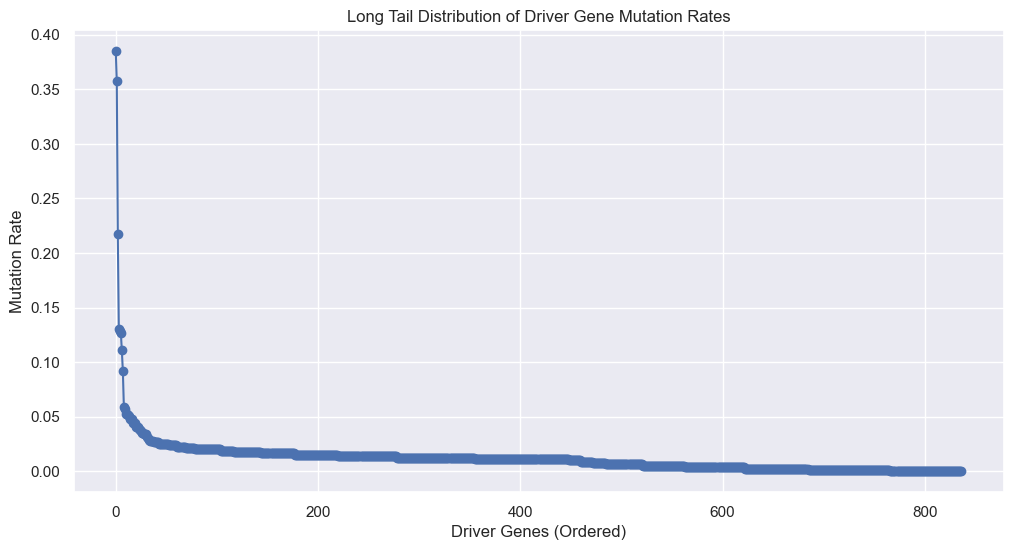

In [63]:
# Ordenar os genes drivers por "MutationRate" em ordem decrescente
drivers_sorted = extreme_genes.sort_values(by='MutationRate', ascending=False)

# Criar o gráfico de long tail
plt.figure(figsize=(12, 6))
plt.plot(drivers_sorted['MutationRate'].values, marker='o')
plt.title('Long Tail Distribution of Driver Gene Mutation Rates')
plt.xlabel('Driver Genes (Ordered)')
plt.ylabel('Mutation Rate')
plt.grid(True)
plt.savefig(f'{FIG_BASE_PATH}long_tail_driver_gene_mutation_rates', dpi=300, bbox_inches='tight')
plt.show()

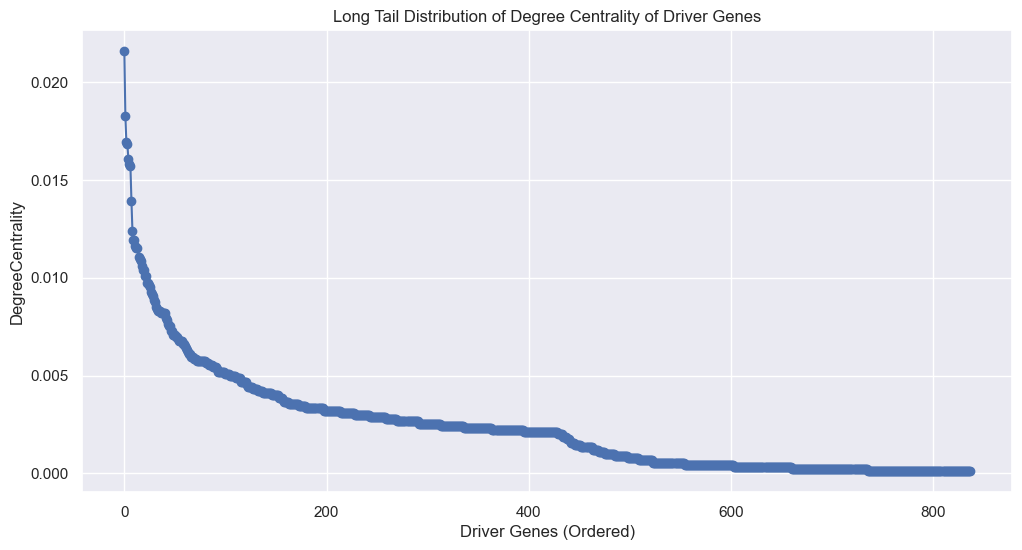

In [64]:
# Ordenar os genes drivers por "DegreeCentrality" em ordem decrescente
drivers_sorted = extreme_genes.sort_values(by='DegreeCentrality', ascending=False)

# Criar o gráfico de long tail para "DegreeCentrality"
plt.figure(figsize=(12, 6))
plt.plot(drivers_sorted['DegreeCentrality'].values, marker='o')
plt.title('Long Tail Distribution of Degree Centrality of Driver Genes')
plt.xlabel('Driver Genes (Ordered)')
plt.ylabel('DegreeCentrality')
plt.grid(True)
plt.savefig(f'{FIG_BASE_PATH}long_tail_driver_gene_degree_centrality', dpi=300, bbox_inches='tight')
plt.show()

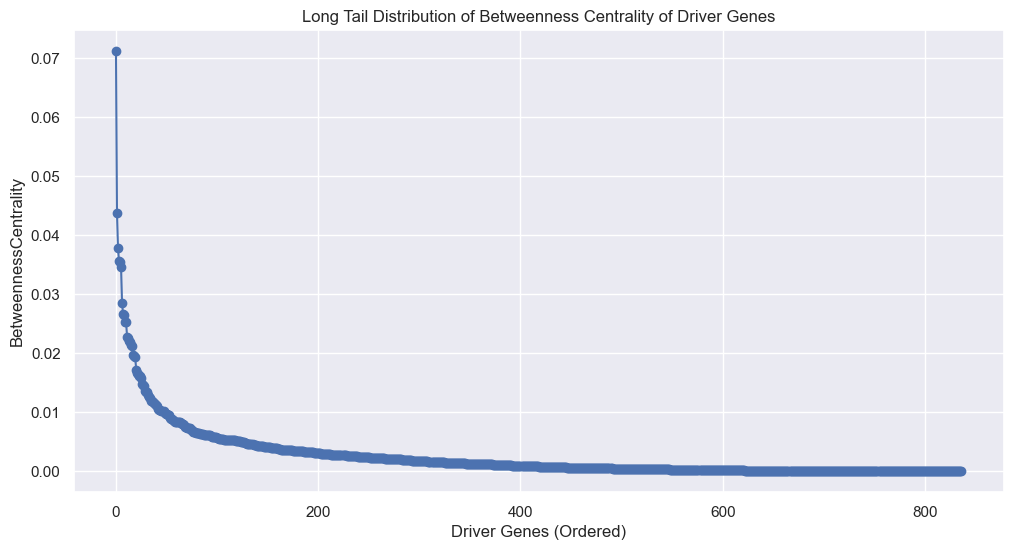

In [65]:
# Ordenar os genes drivers por "BetweennessCentrality" em ordem decrescente
drivers_sorted = extreme_genes.sort_values(by='BetweennessCentrality', ascending=False)

# Criar o gráfico de long tail para "BetweennessCentrality"
plt.figure(figsize=(12, 6))
plt.plot(drivers_sorted['BetweennessCentrality'].values, marker='o')
plt.title('Long Tail Distribution of Betweenness Centrality of Driver Genes')
plt.xlabel('Driver Genes (Ordered)')
plt.ylabel('BetweennessCentrality')
plt.savefig(f'{FIG_BASE_PATH}long_tail_driver_gene_betweenness_centrality', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

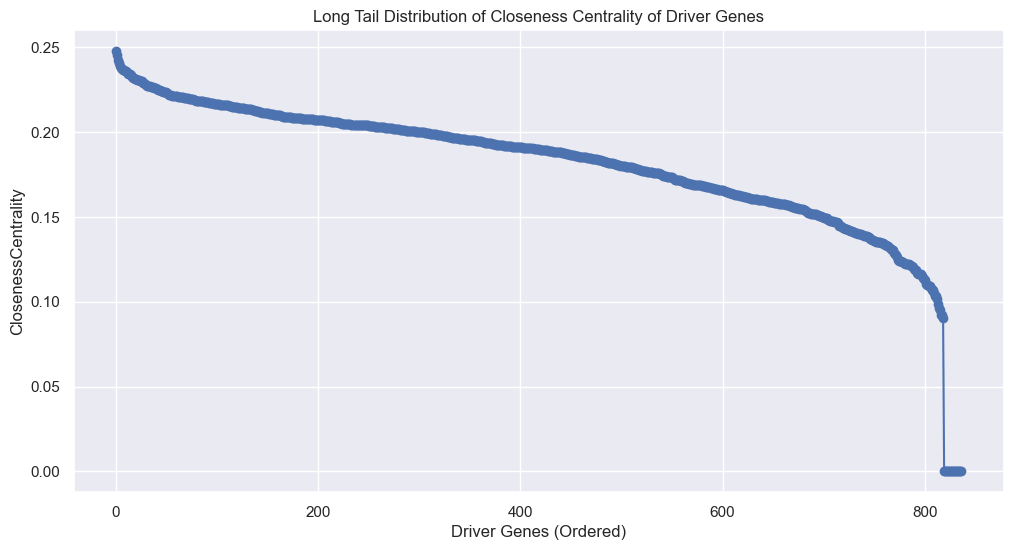

In [66]:
# Ordenar os genes drivers por "ClosenessCentrality" em ordem decrescente
drivers_sorted = extreme_genes.sort_values(by='ClosenessCentrality', ascending=False)

# Criar o gráfico de long tail para "ClosenessCentrality"
plt.figure(figsize=(12, 6))
plt.plot(drivers_sorted['ClosenessCentrality'].values, marker='o')
plt.title('Long Tail Distribution of Closeness Centrality of Driver Genes')
plt.xlabel('Driver Genes (Ordered)')
plt.ylabel('ClosenessCentrality')
plt.grid(True)
plt.savefig(f'{FIG_BASE_PATH}long_tail_driver_gene_closeness_centrality', dpi=300, bbox_inches='tight')
plt.show()

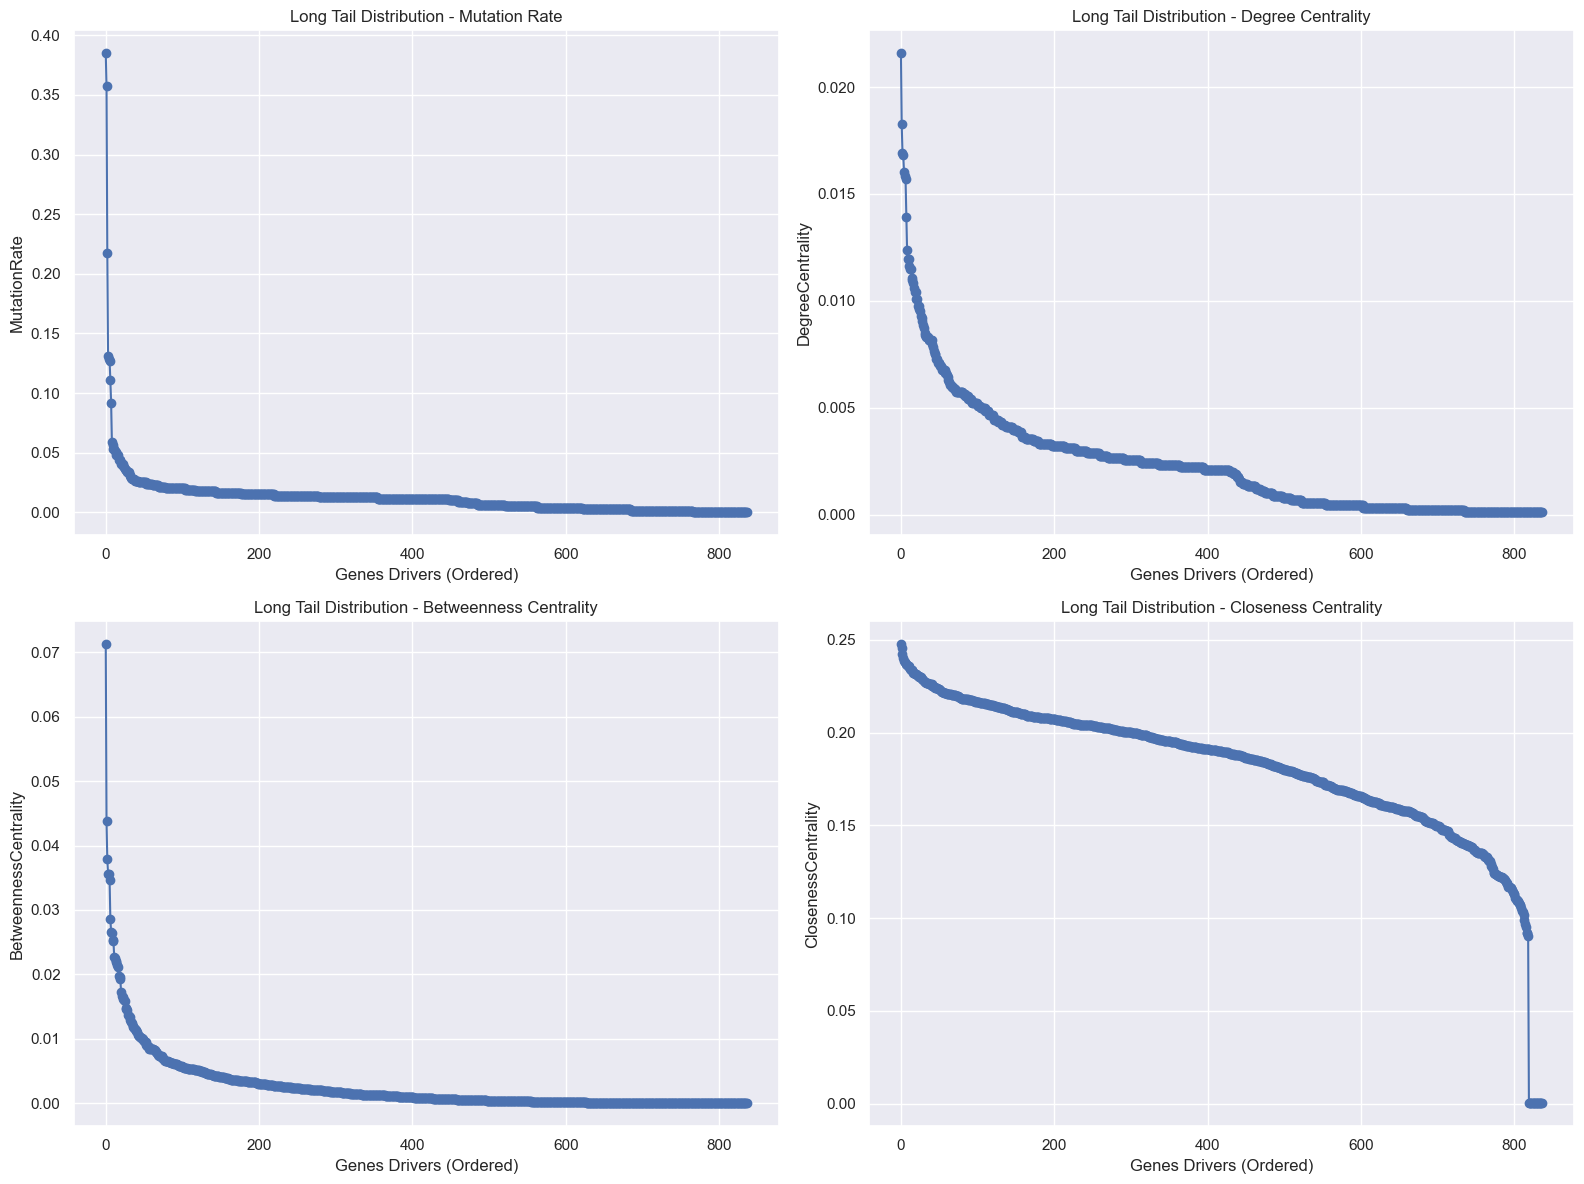

In [67]:
import matplotlib.pyplot as plt

# Criar subgráficos em uma grade 2x2 sem compartilhar o eixo Y
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=False)

# Lista das colunas a serem plotadas e seus títulos
columns = ['MutationRate', 'DegreeCentrality', 'BetweennessCentrality', 'ClosenessCentrality']
titles = [
'Long Tail Distribution - Mutation Rate',
'Long Tail Distribution - Degree Centrality',
'Long Tail Distribution - Betweenness Centrality',
'Long Tail Distribution - Closeness Centrality'
]

# Criar gráficos de long tail para cada coluna
for i, col in enumerate(columns):
    row = i // 2  # Linha atual (0 ou 1)
    col_idx = i % 2  # Coluna atual (0 ou 1)
    
    # Ordenar os genes drivers pela coluna atual em ordem decrescente
    drivers_sorted = extreme_genes.sort_values(by=col, ascending=False)
    
    # Criar o gráfico de long tail no subgráfico correspondente
    axes[row, col_idx].plot(drivers_sorted[col].values, marker='o')
    axes[row, col_idx].set_title(titles[i])
    axes[row, col_idx].set_xlabel('Genes Drivers (Ordered)')
    axes[row, col_idx].set_ylabel(col)  # Mostrar o rótulo do eixo Y em cada gráfico
    axes[row, col_idx].grid(True)

# Ajustar layout e exibir os subgráficos
plt.tight_layout()
plt.savefig(FIG_BASE_PATH+'longtail_drivers_network_metrics.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()


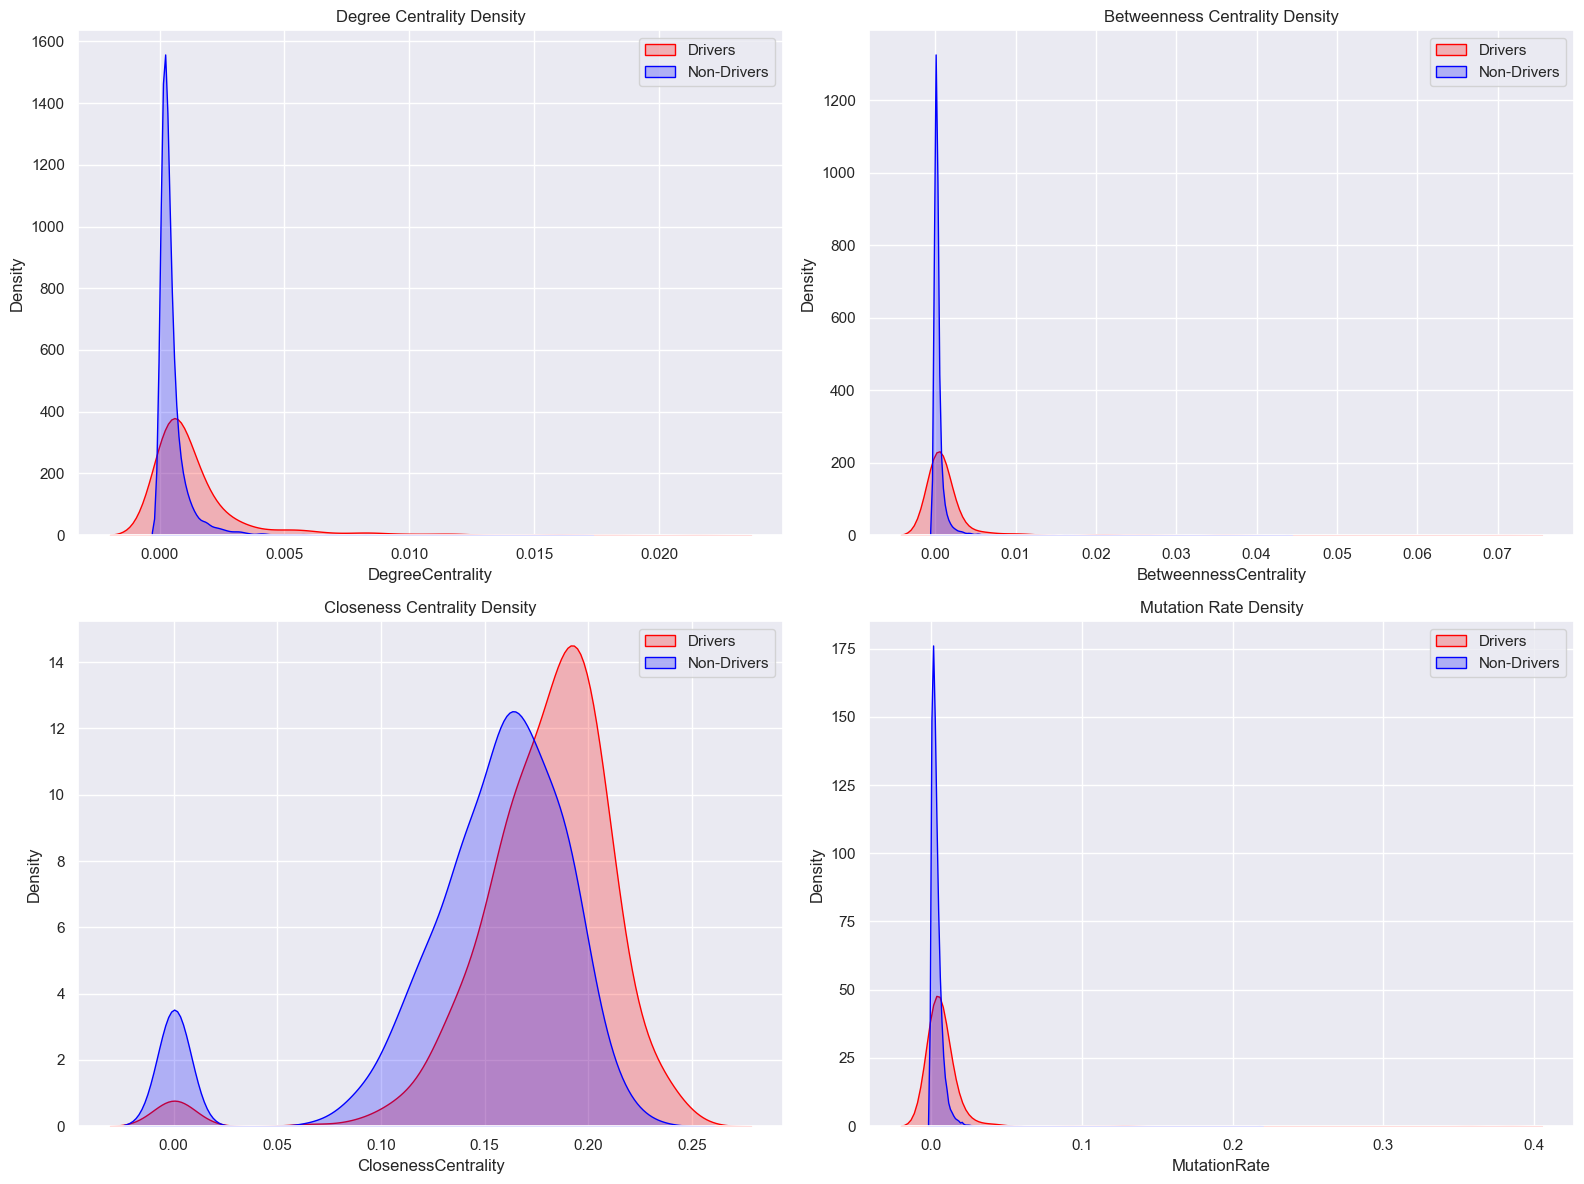

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar genes drivers e não drivers
non_drivers_df = merged_df[merged_df['isDriver'] != 1]
drivers_df = merged_df[merged_df['isDriver'] == 1]

# Criar gráficos de densidade para comparar centralidades entre drivers e não-drivers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

centralities = ['DegreeCentrality', 'BetweennessCentrality', 'ClosenessCentrality', 'MutationRate']
titles = [
    'Degree Centrality Density',
    'Betweenness Centrality Density',
    'Closeness Centrality Density',
    'Mutation Rate Density'
]

for i, col in enumerate(centralities):
    row, col_idx = i // 2, i % 2
    sns.kdeplot(data=drivers_df[col], ax=axes[row, col_idx], label='Drivers', color='red', shade=True)
    sns.kdeplot(data=non_drivers_df[col], ax=axes[row, col_idx], label='Non-Drivers', color='blue', shade=True)
    axes[row, col_idx].set_title(titles[i])
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Density')
    axes[row, col_idx].legend()

plt.tight_layout()
plt.savefig(FIG_BASE_PATH+'distribution_drivers_network_metrics.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()


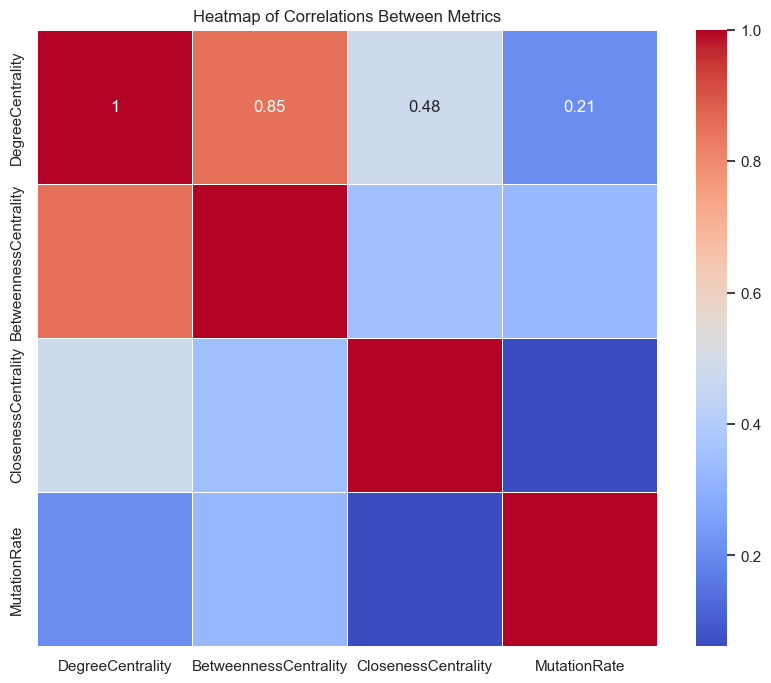

In [69]:
import seaborn as sns

# Calcular a correlação das métricas
metrics = ['DegreeCentrality', 'BetweennessCentrality', 'ClosenessCentrality', 'MutationRate']
corr_matrix = drivers_df[metrics].corr()

# Criar o mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations Between Metrics')
plt.savefig(FIG_BASE_PATH+'heatmap_correlations_between_metrics.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()


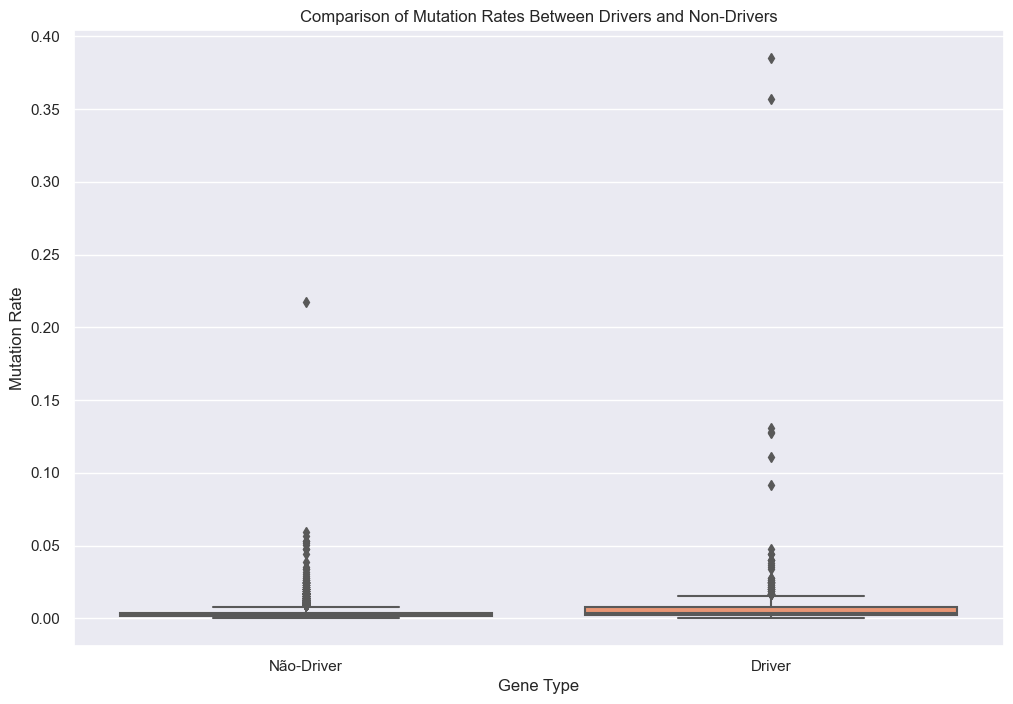

In [70]:
# Adicionar uma coluna 'Tipo' para indicar se é driver ou não-driver
merged_df['Tipo'] = merged_df.apply(lambda row: 'Driver' if row['isDriver'] == 1 else 'Não-Driver', axis=1)

# Criar o boxplot para comparar a taxa de mutação
plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_df, x='Tipo', y='MutationRate', palette='Set2')
plt.title('Comparison of Mutation Rates Between Drivers and Non-Drivers')
plt.xlabel('Gene Type')
plt.ylabel('Mutation Rate')
plt.savefig(FIG_BASE_PATH+'comparison_of_mutation_rates_between_drivers_and_non_drivers.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()


In [71]:
# Obter os índices válidos (interseção entre os índices do DataFrame e os índices dos embeddings)
valid_driver_indices = drivers_df.index.intersection(range(len(embeddings)))
valid_non_driver_indices = merged_df[merged_df['isDriver'] != 1].index.intersection(range(len(embeddings)))

# Filtrar os embeddings dos genes drivers e não drivers usando os índices válidos
driver_embeddings = embeddings[valid_driver_indices]
non_driver_embeddings = embeddings[valid_non_driver_indices]

# Verificar se os embeddings dos genes drivers foram selecionados corretamente
print(f"Total de genes drivers selecionados: {len(driver_embeddings)}")
print(f"Total de genes não drivers selecionados: {len(non_driver_embeddings)}")

Total de genes drivers selecionados: 604
Total de genes não drivers selecionados: 8435
